<a href="https://colab.research.google.com/github/Schiessl/AgoraVAI/blob/main/Dividend_Aristocrats_BR_IDIV.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Importa bibliotecas

In [ ]:
import yfinance as yf
import pandas as pd
import numpy as np
import time
import datetime
from scipy.stats import trim_mean
import matplotlib.pyplot as plt
import matplotlib.colors as mcolors
import seaborn as sns
from datetime import datetime, timedelta
import plotly.graph_objects as go
from plotly.subplots import make_subplots
from pandas.core.series import Series



#Pagadoras de Dividendos BR

A partir da lista de todos os ativos do Bovespa, procuramos as empresas pagadoras de dividendos.

## Preço Justo de Gordon e Graham

### Funções para gerar indicadores

In [ ]:

def years_of_dividend_growth(ticker, year_of_test=None):
    """
    Função para calcular a quantidade de anos de crescimento dos dividendos para um ativo específico.
    Parâmetros:
    ticker (str): Símbolo do ativo.
    year_of_test (int): Ano específico para testar. Se for None, o ano atual é usado.
    Retorna:
    int: A quantidade de anos consecutivos de crescimento de dividendos.
    """
    # Verifique se o ano de teste é fornecido ou determine o ano atual
    if year_of_test is None:
        current_year = datetime.now().year
        if datetime.now().month < 12:  # Se o ano ainda não está completo
            year_of_test = current_year - 1
        else:
            year_of_test = current_year
    # Obtenha informações sobre o ativo usando yfinance
    stock = yf.Ticker(ticker)
    dividends = stock.dividends
    # Verifique se os dividendos são uma série do Pandas
    if not isinstance(dividends, Series):
        print(f"Dividendos para {ticker} não estão disponíveis.")
        return 0
    # Agregue os dividendos anuais e filtre pelo ano de teste
    dividends_annual = dividends.resample('Y').sum()
    dividends_annual = dividends_annual[dividends_annual.index.year <= year_of_test]
    # Contagem de anos de aumento de dividendos
    years_of_increase = 0
    for i in range(len(dividends_annual) - 1, 0, -1):
        if dividends_annual.iloc[i] > dividends_annual.iloc[i-1]:
            years_of_increase += 1
        else:
            break
    return years_of_increase


In [ ]:

def years_of_consecutive_dividends(ticker, year_of_test=None):
    """
    Função para contar o número de anos consecutivos com dividendos pagos por um ativo específico.
    :param ticker: símbolo do ativo
    :param year_of_test: ano até o qual verificar os dividendos (opcional)
    :return: número de anos consecutivos com dividendos pagos
    """
    # Obtendo o ano, mês e dia atuais
    current_year = datetime.now().year
    current_month = datetime.now().month
    current_day = datetime.now().day
    # Determinando o ano de teste com base na data atual e verificando se o ano está completo
    if year_of_test is None:
        if current_month < 12 or (current_month == 12 and current_day < 31):  # Se o ano ainda não está completo
            year_of_test = current_year - 1
        else:
            year_of_test = current_year
    # Buscando os dados do ativo
    stock = yf.Ticker(ticker)
    dividends = stock.dividends
    # Verificando se os dividendos estão disponíveis
    if not isinstance(dividends, Series):
        print(f"Dividendos para {ticker} não estão disponíveis.")
        return 0
    # Resumindo os dividendos por ano
    dividends_annual = dividends.resample('Y').sum()
    # Filtrando os dividendos pelo ano especificado
    dividends_annual = dividends_annual[dividends_annual.index.year <= year_of_test]
    # Contando o número de anos consecutivos com dividendos
    years_of_dividends = 0
    for i in range(len(dividends_annual) - 1, 0, -1):
        if dividends_annual.iloc[i] > 0:
            years_of_dividends += 1
        else:
            break
    return years_of_dividends


In [ ]:
def dividend_growth(ticker):
    """
    Função para calcular o crescimento de dividendos de um ativo específico em um e cinco anos.
    Parâmetros:
    ticker (str): Símbolo do ativo.
    Retorna:
    one_year_growth (float): O crescimento dos dividendos em um ano, ou None se os dados não estiverem disponíveis.
    five_year_growth (float): O crescimento dos dividendos em cinco anos, ou None se os dados não estiverem disponíveis.
    """
    # Obtenha informações sobre o ativo usando yfinance
    stock = yf.Ticker(ticker)
    dividends = stock.dividends
    # Verifique se os dividendos são uma lista e se estão vazios
    if isinstance(dividends, list) and not dividends:
        print(f"Dividendos para {ticker} não estão disponíveis.")
        return None, None
    # Agregue os dividendos anuais
    dividends_annual = dividends.resample('Y').sum()
    # Removendo o último ano se ele ainda não estiver completo
    if dividends_annual.index[-1].year == datetime.now().year:
        dividends_annual = dividends_annual.iloc[:-1]
    # Calcule o crescimento de dividendos de um ano, se disponível
    one_year_growth = None
    if len(dividends_annual) > 1:
        one_year_growth = (dividends_annual.iloc[-1] / dividends_annual.iloc[-2]) - 1
    # Calcule o crescimento de dividendos de cinco anos, se disponível
    five_year_growth = None
    if len(dividends_annual) > 5:
        five_year_growth = (dividends_annual.iloc[-1] / dividends_annual.iloc[-6])**(1/5) - 1
    return one_year_growth, five_year_growth


In [ ]:
def get_additional_data(ticker):
    """
    Função para obter dados adicionais de um ativo específico, como dividendos por ação (TTM),
    valor de mercado, relação P/L, proporção de pagamento, beta, 52 semanas de alta e 52 semanas de baixa.
    Parâmetros:
    ticker (str): Símbolo do ativo.
    Retorna:
    tuple: Uma tupla contendo os valores para os dados adicionais listados acima.
    """
    # Obtenha informações sobre o ativo usando yfinance
    stock = yf.Ticker(ticker)
    info = stock.info
    # Recupere os dividendos por ação no último ano
    dividends_per_share_ttm = info.get('trailingAnnualDividendRate')
    # Recupere o valor de mercado e converta para milhões
    market_cap = info.get('marketCap')
    market_cap_m = market_cap / 1_000_000 if market_cap else None
    # Recupere outras informações financeiras relevantes
    trailing_pe_ratio = info.get('trailingPE')
    payout_ratio = info.get('payoutRatio')
    beta = info.get('beta')
    _52_week_high = info.get('fiftyTwoWeekHigh')
    _52_week_low = info.get('fiftyTwoWeekLow')
    return dividends_per_share_ttm, market_cap_m, trailing_pe_ratio, payout_ratio, beta, _52_week_high, _52_week_low


In [ ]:
def gordon_price(D, k, g):
    """
    Calcula o preço justo de um ativo usando o modelo de Gordon Growth.

    Parâmetros:
    D (float): Dividendos por ação.
    k (float): Taxa de desconto.
    g (float): Taxa de crescimento dos dividendos.

    Retorna:
    float: Preço justo de Gordon.
    """
    return D / (k - g) if D != None else None


In [ ]:
def graham_price(eps, bvps):
    """
    Calcula o preço justo de um ativo usando a fórmula de Graham.

    Parâmetros:
    eps (float): Lucro por ação.
    bvps (float): Valor contábil por ação.

    Retorna:
    float: Preço justo de Graham.
    """
    return (22.5 * eps * bvps) ** 0.5 if 22.5 * eps * bvps > 0 else None


#Lista de ativos
IDIV ->
https://www.b3.com.br/pt_br/market-data-e-indices/indices/indices-de-segmentos-e-setoriais/indice-dividendos-idiv-composicao-da-carteira.htm

In [ ]:
# Exemplo de stocks pagadoras de dividendos
# dividend_aristocrats = ['JPM', 'USB', 'PFE', 'WMB', 'KHC', 'KO','ALB','O']
dividend_aristocrats = ['ABCB4.SA','ALUP11.SA','B3SA3.SA','BRSR6.SA','BBSE3.SA','BRAP4.SA','BBAS3.SA','AGRO3.SA','CMIG3.SA','CMIG4.SA',
                        'CSMG3.SA','CPLE6.SA','CPFE3.SA','CMIN3.SA','CURY3.SA','DIRR3.SA','ENAT3.SA','EGIE3.SA','FESA4.SA','GGBR4.SA',
                        'GOAU4.SA','MYPK3.SA','RANI3.SA','ITSA4.SA','JBSS3.SA','JHSF3.SA','KEPL3.SA','LAVV3.SA','MRFG3.SA','BEEF3.SA',
                        'PETR3.SA','PETR4.SA','PSSA3.SA','RAPT4.SA','ROMI3.SA','SANB11.SA','CSNA3.SA','TAEE11.SA','VIVT3.SA','TRPL4.SA',
                        'TRIS3.SA','UNIP6.SA','USIM5.SA','VALE3.SA','VBBR3.SA']
# dividend_aristocrats

##Gera arquivo com indicadores

In [ ]:
# Registrar o tempo de início
start_time = time.time()
# Formata o tempo de início como uma string
formatted_start_time = time.strftime("%Y-%m-%d %H:%M:%S", time.localtime(start_time))
print(f"Tempo de início: {formatted_start_time}")

#Cria o arquivo
data = pd.DataFrame(columns=['Ativo', 'Nome', 'Setor', 'Preço atual', 'DY', 'DY Anos Sucessivos', 'DY Anos Crescendo', '1-Ano Dividendo crescimento', '5-Ano Dividendo crescimento (a.a.)',
                             'Dividendos Por Ação (TTM)', 'Valor de Mercado ($MM)', 'P/L', 'Payout', 'Beta', '52-Semana Alta', '52-Semana Baixa',
                             'Preço justo de Gordon', 'Preço justo de Graham'])

k = 0.1  # taxa de desconto
g = 0.05  # taxa de crescimento dos dividendos

for ticker in dividend_aristocrats:
  try:
    stock = yf.Ticker(ticker)
    info = stock.info

    name = info.get('shortName', "Nome não disponível")
    sector = info.get('sector', "Setor não disponível")

    history = stock.history()
    current_price = history.tail(1)['Close'].iloc[0] if not history.empty else None

    # Se o preço atual for None, continue para a próxima iteração
    if current_price is None:
        continue

    dy = info.get('dividendYield', None) * 100 if 'dividendYield' in info else None

    # Preço justo de Gorden e Graham
    D = info.get('dividendRate', None)
    eps = info.get('trailingEps', None)
    bvps = info.get('bookValue', None)

    gordon_price_value = gordon_price(D, k, g)
    graham_price_value = graham_price(eps, bvps)

    years_increase = years_of_dividend_growth(ticker)
    years_consecutive = years_of_consecutive_dividends(ticker)
    one_year_growth, five_year_growth = dividend_growth(ticker)
    additional_data = get_additional_data(ticker)

    new_row = pd.DataFrame({'Ativo': [ticker], 'Nome': [name], 'Setor': [sector], 'Preço atual': [current_price], 'DY': [dy], 'DY Anos Sucessivos': [years_consecutive],
                            'DY Anos Crescendo': [years_increase], '1-Ano Dividendo crescimento': [one_year_growth], '5-Ano Dividendo crescimento (a.a.)': [five_year_growth],
                            'Dividendos Por Ação (TTM)': [additional_data[0]], 'Valor de Mercado ($MM)': [additional_data[1]], 'P/L': [additional_data[2]],
                            'Payout': [additional_data[3]], 'Beta': [additional_data[4]], '52-Semana Alta': [additional_data[5]], '52-Semana Baixa': [additional_data[6]],
                            'Preço justo de Gordon': [gordon_price_value], 'Preço justo de Graham': [graham_price_value]
                            })
    data = pd.concat([data, new_row], ignore_index=True)
  except Exception as e:
      print(f"Erro ao processar o ativo {ticker}: {e}")
      continue

# Após a construção do DataFrame, converter a coluna para numérico:
data['Preço justo de Graham'] = pd.to_numeric(data['Preço justo de Graham'], errors='coerce')

# Registrar o tempo de término
end_time = time.time()

# Formata o tempo de término como uma string
formatted_end_time = time.strftime("%Y-%m-%d %H:%M:%S", time.localtime(end_time))

# Calcula o tempo total de execução
execution_time = end_time - start_time

# Imprime os tempos formatados
print(f"Tempo de término: {formatted_end_time}")
print(f"Tempo total de execução: {execution_time:.6f} segundos")
print(f"Tempo total de execução: {execution_time/60:.6f} minutos")



Tempo de início: 2023-08-21 17:50:29


<ipython-input-89-7b123a9c8f08>:29: RuntimeWarning:

divide by zero encountered in double_scalars

<ipython-input-89-7b123a9c8f08>:29: RuntimeWarning:

divide by zero encountered in double_scalars

<ipython-input-89-7b123a9c8f08>:29: RuntimeWarning:

divide by zero encountered in double_scalars

<ipython-input-89-7b123a9c8f08>:29: RuntimeWarning:

divide by zero encountered in double_scalars

<ipython-input-89-7b123a9c8f08>:29: RuntimeWarning:

divide by zero encountered in double_scalars

<ipython-input-89-7b123a9c8f08>:29: RuntimeWarning:

divide by zero encountered in double_scalars

<ipython-input-89-7b123a9c8f08>:29: RuntimeWarning:

divide by zero encountered in double_scalars

<ipython-input-89-7b123a9c8f08>:29: RuntimeWarning:

divide by zero encountered in double_scalars



Tempo de término: 2023-08-21 17:51:52
Tempo total de execução: 82.942195 segundos
Tempo total de execução: 1.382370 minutos


### Ordenação e corte por Dividendos sucessivos

In [ ]:
#########################
corte = 5 # Defina o valor do corte
#########################
# Filtra o DataFrame para incluir apenas as linhas com 'DY Anos Sucessivos' maior que o corte
data_filtered = data.loc[data['DY Anos Sucessivos'] > corte]
# Ordena o DataFrame filtrado como desejado
rank1 = 'DY'; rank2 = 'DY Anos Sucessivos'; rank3 = 'DY Anos Crescendo';  rank4 = 'P/L'

data_sorted = data_filtered.sort_values(
    by=[rank2, rank3, rank1, rank4],
    ascending=[False, False, False, True])
# Exportar em formato brasileiro
data.to_csv('data.csv', sep=';', decimal=',', index=False)
# data_sorted.head(50)
data_sorted

,Ativo,Nome,Setor,Preço atual,DY,DY Anos Sucessivos,DY Anos Crescendo,1-Ano Dividendo crescimento,5-Ano Dividendo crescimento (a.a.),Dividendos Por Ação (TTM),Valor de Mercado ($MM),P/L,Payout,Beta,52-Semana Alta,52-Semana Baixa,Preço justo de Gordon,Preço justo de Graham
19,GGBR4.SA,GERDAU PN N1,Basic Materials,24.740000,12.460000,22,3,0.182410,1.356066,3.178,41724.010496,3.871675,0.6547,1.25457,32.266666,21.409523,63.6,63.449537
11,CPLE6.SA,COPEL PNB N2,Utilities,8.660000,5.430000,19,0,-0.174222,0.385682,0.367,23490.680832,23.405405,0.5348,0.417738,9.150000,6.180000,9.4,8.136363
23,ITSA4.SA,ITAUSA PN EJS N1,Industrials,9.220000,1.010000,15,1,0.641658,0.108971,0.515,90042.343424,7.038168,0.3488,0.562965,10.090000,7.650000,1.8,15.281702
39,TRPL4.SA,TRAN PAULISTPN N1,Utilities,25.040001,4.200000,15,0,-0.703972,0.069439,1.062,18840.471552,6.677333,None,0.342924,26.080000,21.210000,21.2,47.348112
17,EGIE3.SA,ENGIE BRASILON NM,Utilities,41.810001,2.840000,14,3,0.077444,0.065868,3.548,34113.951744,11.777465,0.2402,0.437373,46.000000,36.440000,23.8,28.576949
8,CMIG3.SA,CEMIG ON N1,Utilities,19.809999,3.810000,14,2,1.426903,1.005218,1.010,35406.409728,10.766304,1.1872,0.533852,21.000000,14.700000,14.6,21.075593
37,TAEE11.SA,TAESA UNT N2,Utilities,34.459999,9.420000,14,0,-0.223230,0.146525,2.471,35614.408704,5.352594,None,0.208869,42.720000,32.510000,65.0,53.034418
43,VALE3.SA,VALE ON EJ NM,Basic Materials,61.110001,6.200000,14,0,-0.482316,0.417415,0.837,265106.784256,4.117925,0.4572,0.813811,98.290000,61.000000,76.8,54.922241
2,B3SA3.SA,B3 ON NM,Financial Services,13.540000,2.020000,14,0,-0.520300,0.254612,0.471,77453.271040,18.053333,0.5087,0.399458,15.980000,10.130000,5.6,7.794229
32,PSSA3.SA,PORTO SEGUROON NM,Financial Services,26.639999,4.780000,13,3,0.207680,0.183533,0.000,17042.647040,12.995122,None,0.576167,29.700000,20.450000,26.0,28.713033


##Histórico de Dividendos das top "n" maiores DY

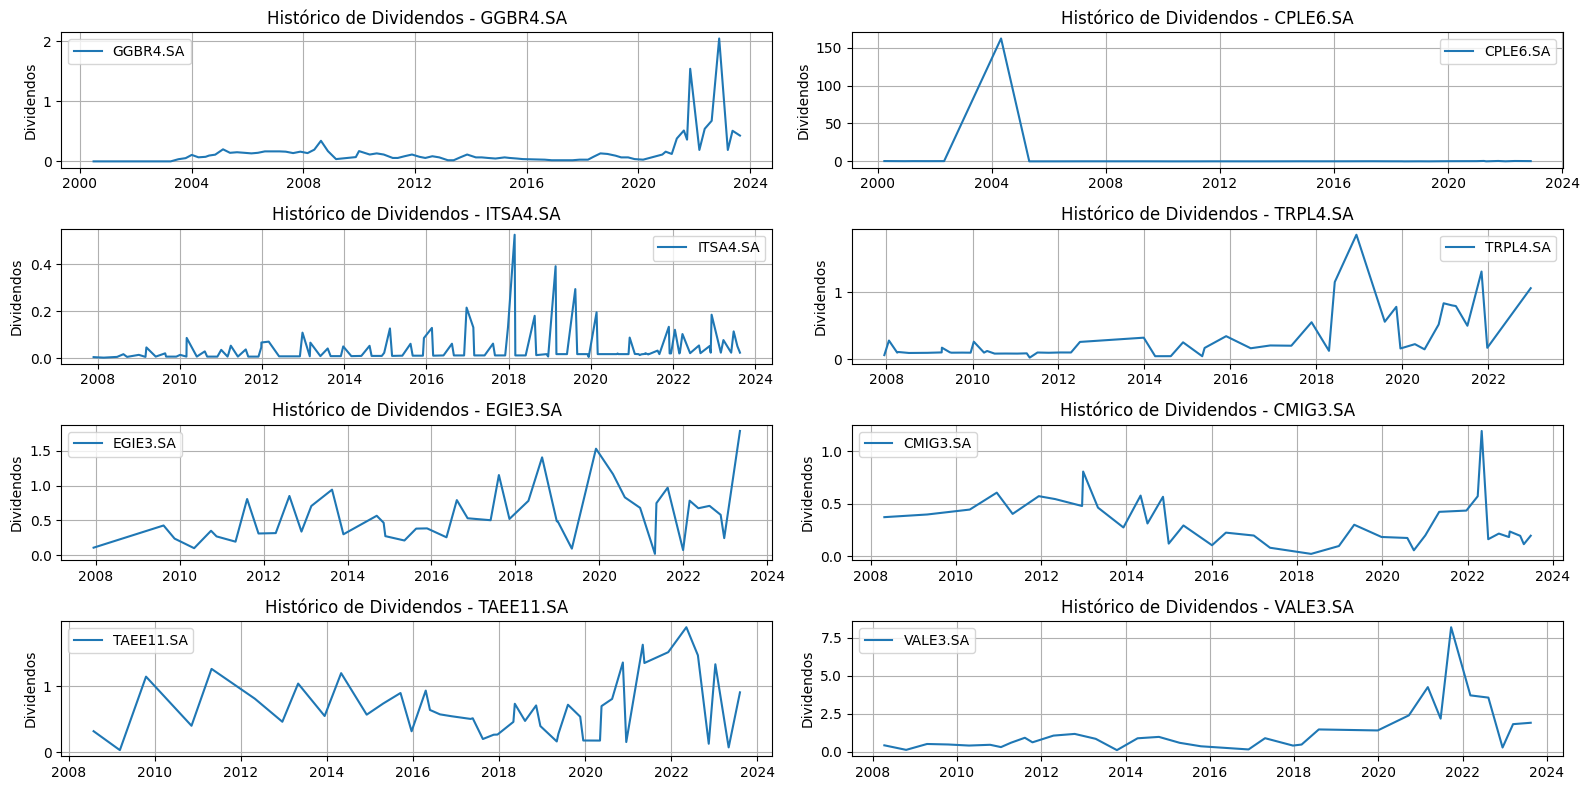

In [ ]:
n = 8 ### Altere para diferentes quantidades. ATENÇÃO: use números pares e altere nrows para mostrar as quantidades que preferir
# Selecionar os cinco principais ativos
top_tickers = data_sorted['Ativo'].head(n)

# Definir o número de linhas e colunas
nrows = 4  ### altere aqui para adequar a visualização
ncols = 2
# Criar uma figura e um conjunto de subplots
fig, axs = plt.subplots(nrows, ncols, figsize=(16, 8))

# Para cada ativo, obter o histórico de dividendos e criar um gráfico
for i, ticker in enumerate(top_tickers):
    # Determine em qual subplot o gráfico deve ir
    row = i // ncols
    col = i % ncols
    # Obtenha o eixo para esse subplot
    ax = axs[row, col]

    stock = yf.Ticker(ticker)
    dividends = stock.dividends

    ax.plot(dividends.index, dividends, label=ticker)
    # ax.set_xlabel("Data")
    ax.set_ylabel("Dividendos")
    ax.set_title(f"Histórico de Dividendos - {ticker}")
    ax.legend()
    ax.grid(True)
# Ajustar o layout para evitar sobreposições
plt.tight_layout()
plt.show()

##Distribuição de setores dos ativos de Dividend Aristocrats

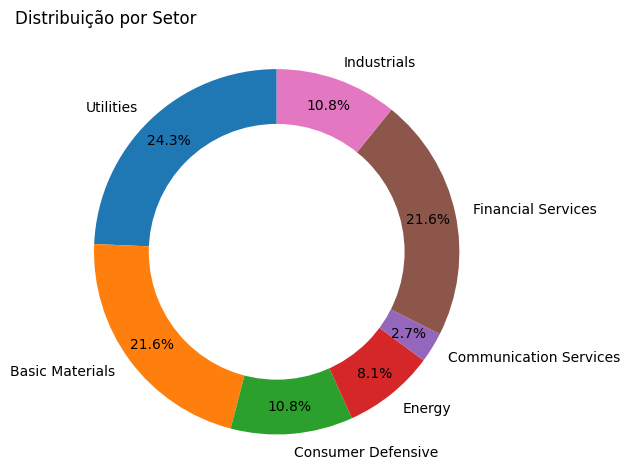

In [ ]:
# Agrupar por setor e contar o número de empresas em cada um
sector_counts = data['Setor'].value_counts()

# Ordenar os dados de modo alternado entre setores grandes e pequenos
sorted_counts = pd.concat([pd.Series(sector_counts[::2]), pd.Series(sector_counts[1::4])])

# Criar gráfico de rosca
fig, ax = plt.subplots()
ax.pie(sorted_counts, labels = sorted_counts.index, autopct='%1.1f%%', startangle=90, pctdistance=0.85)
centre_circle = plt.Circle((0,0),0.70,fc='white')
fig.gca().add_artist(centre_circle)

# Igualar aspecto para garantir que a torta seja desenhada como um círculo
ax.axis('equal')

# Adicionar o título
plt.title("Distribuição por Setor", loc='left', pad=20)

plt.tight_layout()
plt.show()


##Histórico das top "n" pagadoras de dividendos.
Mudar a quantidade no comando top_10 = data_sorted.head(10) caso ver mais ou menos empresas;


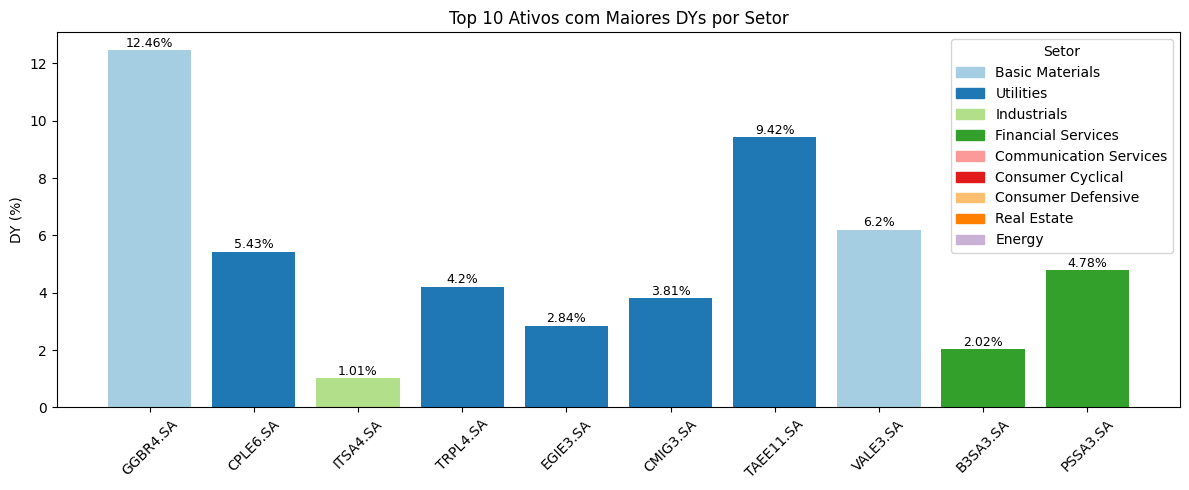

In [ ]:
# Pegamos uma lista de cores do matplotlib
colors = plt.get_cmap('Paired').colors # tab20, Paired, Set3: outras paletas de cores.
# Obtemos uma lista dos setores únicos
sectors = data_sorted['Setor'].unique()
# Criamos um dicionário que mapeia cada setor a uma cor diferente
color_dict = {sector: colors[i] for i, sector in enumerate(sectors)}
# Adicionamos uma nova coluna ao dataframe com as cores correspondentes
data_sorted['Color'] = data_sorted['Setor'].map(color_dict)
################################
n = 10                   ####### Altere a quantidade
################################
# Selecionamos os top n e fazemos uma cópia do resultado
top_n = data_sorted.head(n).copy()
top_n['DY'] = top_n['DY'].fillna(0)  # Substituir NaN por 0

fig, ax = plt.subplots(figsize=(12, 5))
# Criamos o gráfico de barras, passando a coluna de cores para o argumento 'color'
bars = plt.bar(top_n['Ativo'], top_n['DY'], color=top_n['Color'])
# # Adicionamos os valores dos DYs no topo das barras
for bar in bars:
    # Aumentar o valor adicionado a yval
    yval = bar.get_height()
    # Parâmetro 'fontsize' - altere para melhorar a visualição dos rótulos
    plt.text(bar.get_x() + bar.get_width()/2, yval + 0.02, f'{round(yval, 2)}%', ha='center', va='bottom', fontsize=9)
# Criamos uma legenda customizada
handles = [plt.Rectangle((0,0),1,1, color=color_dict[sector]) for sector in sectors]
plt.legend(handles, sectors, title='Setor')
plt.title(f'Top {n} Ativos com Maiores DYs por Setor') # Adicionando a variável n no título
# plt.xlabel('Ativo')
plt.ylabel('DY (%)')  # adicionado o símbolo de percentagem

plt.xticks(rotation=45)
# plt.xticks(fontsize=6)
ticks = ax.get_xticks()
# Obtendo os rótulos atuais do eixo X
labels = top_n['Ativo']
# Selecionando apenas cada n-ésimo rótulo
# mostra apenas cada n-ésimo rótulo
n = 1  ################# Altere o número, caso a visualição esteja ruim
plt.xticks(ticks[::n], labels[::n])

plt.tight_layout()
plt.show()


# ETF do Dividendos - DIVO11.SA
DIVO11 é o código de negociação na Bolsa de Valores de São Paulo (B3) para o ETF (Exchange Traded Fund) conhecido como It Now IDIV. Esse fundo busca replicar o desempenho do índice IDIV, que é o Índice Dividendos da B3.

O IDIV tem como objetivo oferecer uma visão segmentada do mercado acionário, medindo o comportamento das ações das empresas que se destacaram em termos de remuneração dos investidores, sob a forma de dividendos e juros sobre o capital próprio. Site: https://www.itnow.com.br/divo11/composicao/

Assim, o ETF DIVO11 procura investir em uma cesta de ações que seja semelhante à composição do IDIV, permitindo que os investidores ganhem exposição a essas empresas sem ter que comprar cada ação individualmente.

Investir em DIVO11 pode ser uma maneira de buscar uma renda de dividendos potencialmente mais alta, já que o índice se concentra em empresas com um histórico de pagamento de dividendos mais elevados. No entanto, como qualquer investimento, ele vem com riscos, e é sempre uma boa ideia entender completamente esses riscos e conversar com um profissional de investimentos antes de tomar qualquer decisão de investimento.

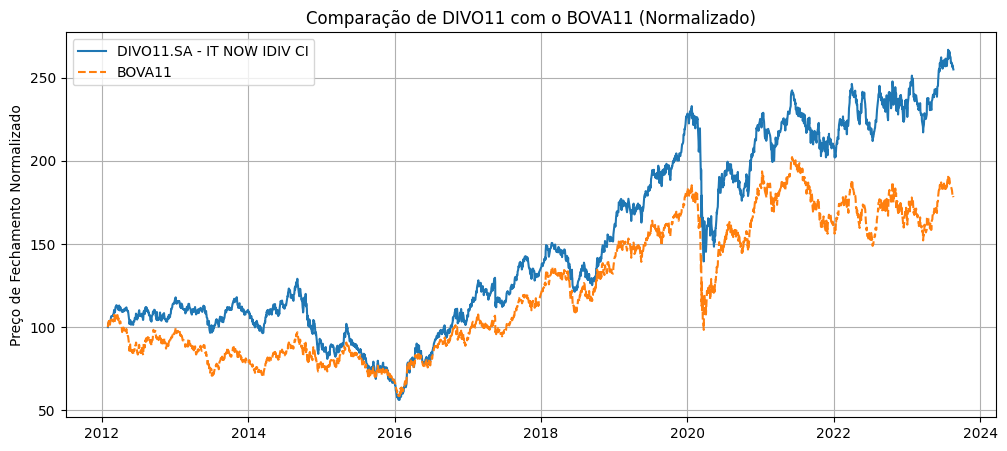

In [ ]:
###########################################
ativo = "DIVO11.SA"  # Insira o ativo aqui!
###########################################
# Baixar os dados do ativo
ticker = yf.Ticker(ativo)

# Obter o histórico de preços do ativo
history = ticker.history(period="30y")
# print(history)
# Obter o nome da empresa
company_name = ticker.info['shortName']

# Baixar os dados do índice S&P 500 (o ticker é "^GSPC")
idx_ticker = yf.Ticker("BOVA11.SA")
idx_history = idx_ticker.history(period="30y")
# print(idx_history)

# Encontrar as datas comuns às duas séries e usar apenas essas datas
common_dates = history.index.intersection(idx_history.index)
history_common = history.loc[common_dates]
idx_common = idx_history.loc[common_dates]

# Normalizar os preços para que comecem em 100
history_common['Close'] = 100 * history_common['Close'] / history_common['Close'].iloc[0]
idx_common['Close'] = 100 * idx_common['Close'] / idx_common['Close'].iloc[0]

# Plotar o preço de fechamento do ativo
plt.figure(figsize=(12,5))
plt.plot(history_common['Close'], label=f'{ticker.ticker} - {company_name}')

# Plotar o preço de fechamento do S&P 500
plt.plot(idx_common['Close'], label='BOVA11', linestyle='--')

plt.title(f'Comparação de {ticker.ticker.split(".")[0]} com o {idx_ticker.ticker.split(".")[0]} (Normalizado)')  # Usar split para remover o sufixo
plt.ylabel('Preço de Fechamento Normalizado')
plt.grid(True)
plt.legend()  # Adicionar uma legenda
plt.show()


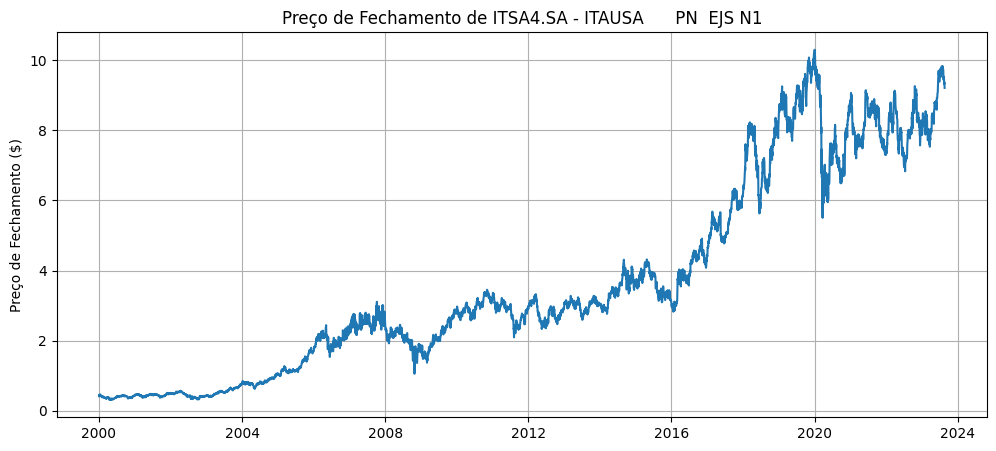

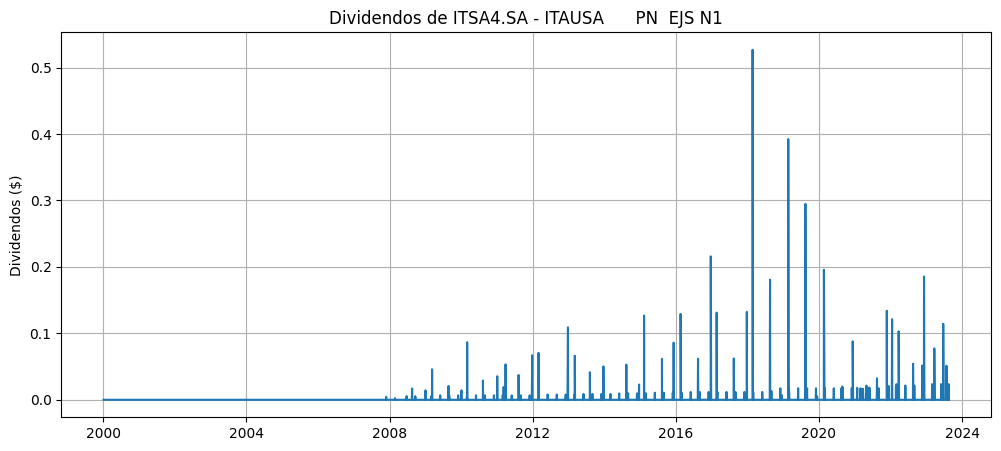

In [ ]:
ativo = "itsa4.sa" ### Insidra o ativo aqui!
# Baixar os dados do ETF
ticker = yf.Ticker(ativo)

# Obter o histórico de preços
history = ticker.history(period="30y")
# Obter o nome da empresa
company_name = ticker.info['shortName']

# Plotar o preço de fechamento
plt.figure(figsize=(12,5))
# plt.figure(figsize=(2,2))
plt.plot(history['Close'])
plt.title(f'Preço de Fechamento de {ticker.ticker} - {company_name}')  # Inclui o ticker e o nome da empresa no título
# plt.xlabel('Data')
plt.ylabel('Preço de Fechamento ($)')
plt.grid(True)
plt.show()

# # Plotar Dividendos
plt.figure(figsize=(12,5))
plt.plot(history.index, history['Dividends'])  # Mudamos a função plt.plot para plt.bar
plt.title(f'Dividendos de {ticker.ticker} - {company_name}')  # Inclui o ticker e o nome da empresa no título
# plt.xlabel('Data')
plt.ylabel('Dividendos ($)')
plt.grid(True)
plt.show()


##Indicadores

In [ ]:

################################################################
ticker = yf.Ticker(ativo) # Define ticker
d_util = 252 # quantidade média de dias de mercado no ano
anos = 30
################################################################
# Get data from the last n years
end_date = datetime.today()
start_date = end_date - timedelta(days=anos*365)

data = ticker.history(start=start_date, end=end_date)
# data.head()

In [ ]:
# Calcular os retornos logaritmicos diários
data['Log Returns'] = np.log(data['Close'] / data['Close'].shift(1))

# Calcular o retorno anual e o desvio padrão anual
data['Year'] = data.index.year
annual_returns = data.groupby('Year')['Log Returns'].sum()
annual_std_dev = data.groupby('Year')['Log Returns'].std() * np.sqrt(d_util)

# Calcular o preço no final de cada ano
annual_price = data['Close'].resample('Y').last().reset_index()
annual_price['Year'] = annual_price['Date'].dt.year

# Criar um DataFrame para armazenar os resultados
annual_data = pd.DataFrame({
    'Annual Returns': annual_returns,
    'Annual Std Dev': annual_std_dev})

# Fazendo o merge de annual_data e annual_price no 'Year'
annual_data = pd.merge(annual_data, annual_price, on='Year')

# Removendo a coluna 'Date' de annual_price
annual_data.drop('Date', axis=1, inplace=True)


In [ ]:
# Calcular os dividendos anuais por ação
annual_dividends = data['Dividends'].resample('Y').sum().reset_index()
annual_dividends['Year'] = annual_dividends['Date'].dt.year

# Juntar os dividendos ao dataframe annual_data
annual_data = pd.merge(annual_data, annual_dividends, on='Year')
# Removendo a coluna 'Date'
annual_data.drop('Date', axis=1, inplace=True)

# Calcular o Dividend Yield
annual_data['Dividend Yield'] = annual_data['Dividends'] / annual_data['Close']
# Calcular a taxa de crescimento de dividendos
annual_data['Dividend Growth Rate'] = annual_data['Dividends'].pct_change()


In [ ]:
annual_data.rename(columns={
    'Year': 'Ano',
    'Annual Returns': 'Retorno Anual',
    'Annual Std Dev': 'DP Anual',
    'Close': 'Cotação',
    'Dividends': 'Dividendos',
    'Dividend Yield': 'DY',
    'Dividend Growth Rate': 'Tx Cresc Dividendos'
}, inplace=True)

annual_data.tail()

,Ano,Retorno Anual,DP Anual,Cotação,Dividendos,DY,Tx Cresc Dividendos
19,2019,0.221678,0.240679,10.110688,0.761602,0.075326,-0.008935
20,2020,-0.144841,0.445590,8.747365,0.390260,0.044615,-0.487580
21,2021,-0.180980,0.267205,7.299257,0.380977,0.052194,-0.023787
22,2022,0.118443,0.240959,8.217085,0.625434,0.076114,0.641658
23,2023,0.115160,0.222556,9.220000,0.313573,0.034010,-0.498631


In [ ]:

# Criar um subplot para cada coluna do DataFrame (exceto 'Ano')
fig = make_subplots(rows=len(annual_data.columns)-1, cols=1,
                    subplot_titles=[f'Acompanhamento de {col}' for col in annual_data.columns[1:]])

# Adicionar um gráfico de barras para cada coluna (exceto 'Ano')
for i, col in enumerate(annual_data.columns[1:], start=1):  # Começar do segundo campo
    # Separar valores positivos e negativos
    positive_values = annual_data[col].clip(lower=0)
    negative_values = annual_data[col].clip(upper=0)

    fig.add_trace(go.Bar(x=annual_data['Ano'], y=positive_values, name=col, marker_color='blue'),
                  row=i, col=1)

    fig.add_trace(go.Bar(x=annual_data['Ano'], y=negative_values, name=col, marker_color='red'),
                  row=i, col=1)

# Adicionar uma linha horizontal em y=0 para cada gráfico
for i in range(1, len(annual_data.columns)):  # Começar do segundo campo
    fig.add_shape(type="line",
                  x0=annual_data['Ano'].min(), x1=annual_data['Ano'].max(), y0=0, y1=0,
                  line=dict(color="Black",width=1),
                  row=i, col=1)

# Atualizar layout do gráfico
fig.update_layout(height=500*(len(annual_data.columns)-1), width=900,
                  title_text="Dashboard", showlegend=False)

# Salvar o gráfico como um arquivo HTML
fig.write_html("dashboard.html")


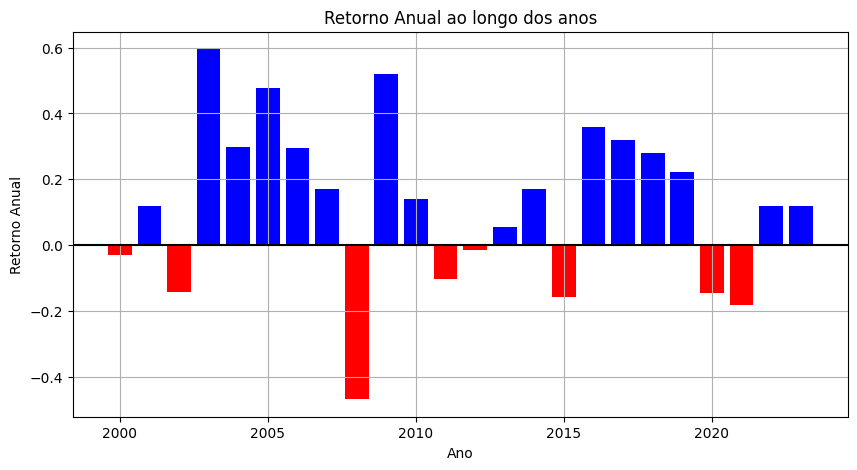

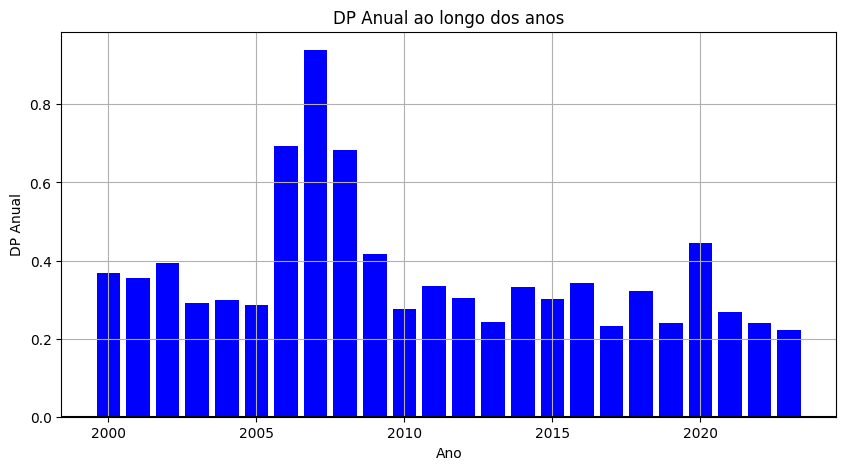

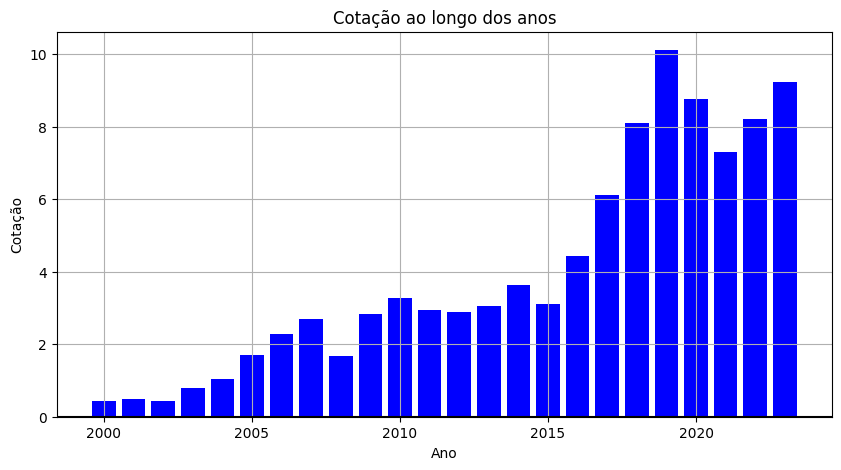

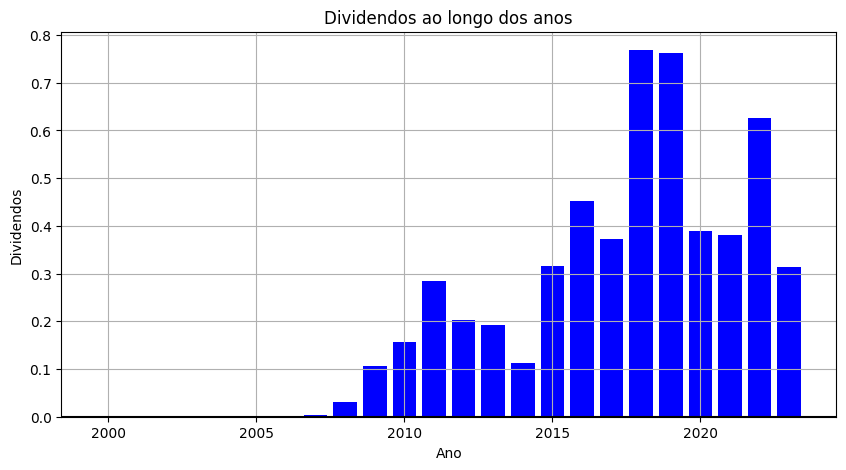

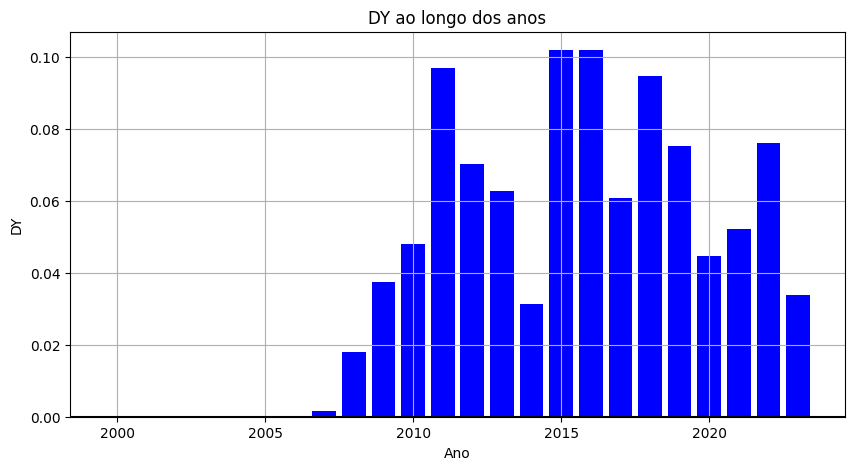

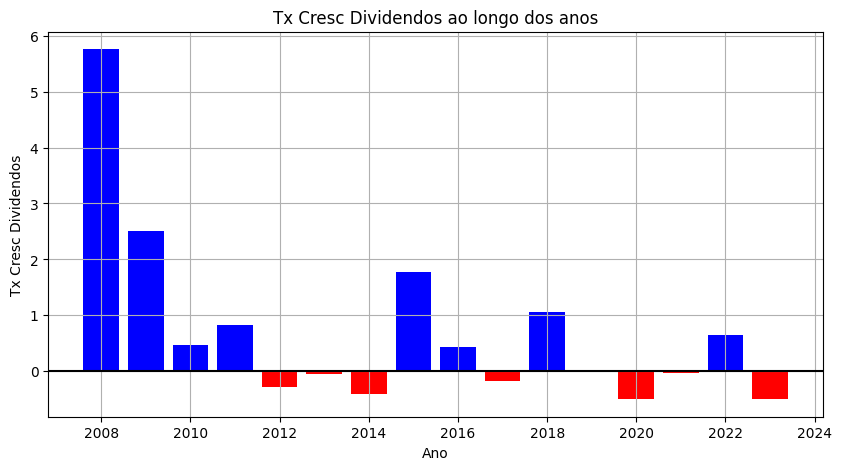

In [ ]:

# Lista de todas as colunas que são ativos
assets = ['Retorno Anual', 'DP Anual', 'Cotação', 'Dividendos', 'DY', 'Tx Cresc Dividendos']

for asset in assets:
    plt.figure(figsize=(10,5))

    # condição para determinar as cores das barras
    colors = np.where(annual_data[asset]<0, 'r', 'b')

    plt.bar(annual_data['Ano'], annual_data[asset], color=colors)
    plt.axhline(0, color='black')  # adiciona uma linha horizontal no zero

    plt.xlabel('Ano')
    plt.ylabel(asset)
    plt.title(f'{asset} ao longo dos anos')
    plt.grid(True)

    plt.show()


##Formatar os dados finais para o dashboard
ATENÇÃO: os dados formatados não são apropriadas para manipulação, pois não são numéricos.

In [ ]:
data_final = annual_data.copy()  # Faz uma cópia do DataFrame original para evitar a modificação do DataFrame original

# Multiplica os valores por 100 e arredonda para 2 casas decimais
data_final['Retorno Anual'] = data_final['Retorno Anual'].multiply(100).round(2)
data_final['DP Anual'] = data_final['DP Anual'].multiply(100).round(2)
data_final['DY'] = data_final['DY'].multiply(100).round(2)
data_final['Tx Cresc Dividendos'] = data_final['Tx Cresc Dividendos'].multiply(100).round(2)
data_final = data_final.fillna('')

# Adiciona o símbolo de porcentagem (%) ao final dos valores
data_final['Retorno Anual'] = data_final['Retorno Anual'].astype(str) + '%'
data_final['DP Anual'] = data_final['DP Anual'].astype(str) + '%'
data_final['DY'] = data_final['DY'].astype(str) + '%'
data_final['Tx Cresc Dividendos'] = data_final['Tx Cresc Dividendos'].astype(str) + '%'
# Formatando as colunas 'Cotação' e 'Dividendos'
data_final['Cotação'] = data_final['Cotação'].apply(lambda x: f'R$ {x:,.2f}')
data_final['Dividendos'] = data_final['Dividendos'].apply(lambda x: f'R$ {x:,.2f}')

data_final

,Ano,Retorno Anual,DP Anual,Cotação,Dividendos,DY,Tx Cresc Dividendos
0,2000,-3.06%,36.75%,R$ 0.44,R$ 0.00,0.0%,%
1,2001,11.72%,35.45%,R$ 0.50,R$ 0.00,0.0%,%
2,2002,-14.35%,39.35%,R$ 0.43,R$ 0.00,0.0%,%
3,2003,59.54%,29.04%,R$ 0.78,R$ 0.00,0.0%,%
4,2004,29.93%,29.97%,R$ 1.05,R$ 0.00,0.0%,%
5,2005,47.74%,28.67%,R$ 1.69,R$ 0.00,0.0%,%
6,2006,29.38%,69.44%,R$ 2.27,R$ 0.00,0.0%,%
7,2007,16.94%,93.9%,R$ 2.69,R$ 0.00,0.17%,inf%
8,2008,-46.9%,68.26%,R$ 1.68,R$ 0.03,1.8%,575.65%
9,2009,52.0%,41.58%,R$ 2.83,R$ 0.11,3.75%,250.74%


In [ ]:
AALR3 	ALLIAR 	CENTRO DE IMAGEM DIAGNOSTICOS S.A.
ABCB3 	ABC Brasil 	BANCO ABC BRASIL S/A
ABCB4 	ABC Brasil 	BANCO ABC BRASIL S/A
ABEV3 	AMBEV S/A 	AMBEV S.A.
ABRE3 	SOMOS EDUCA 	SOMOS EDUCAÇÃO S.A.
ABYA3 	ABYARA 	ABYARA PLANEJAMENTO IMOBILIARIO S.A.
ACES3 	ARCELORMITTAL INOX BRASIL 	ARCELORMITTAL INOX BRASIL S.A.
ACES4 	ARCELORMITTAL INOX BRASIL 	ARCELORMITTAL INOX BRASIL S.A.
ADHM3 	ADVANCED-DH 	ADVANCED DIGITAL HEALTH MEDICINA PREVENTIVA S.A.
AEDU11 	ANHANGUERA EDUCACIONAL PARTICIPAÇÕES SA 	ANHANGUERA EDUCACIONAL PARTICIPAÇÕES S.A
AEDU3 	ANHANGUERA EDUCACIONAL PARTICIPAÇÕES SA 	ANHANGUERA EDUCACIONAL PARTICIPAÇÕES S.A
AELP3 	AES ELPA 	AES ELPA SA
AERI3 	AERIS 	AERIS IND. E COM. DE EQUIP. GERACAO DE ENERGIA S/A
AESB3 	AES BRASIL 	AES BRASIL ENERGIA S.A.
AESL3 	AES SUL DISTRIB. GAÚCHA DE ENERGIA S.A. 	AES SUL DISTRIB. GAÚCHA DE ENERGIA S.A.
AESL4 	AES SUL DISTRIB. GAÚCHA DE ENERGIA S.A. 	AES SUL DISTRIB. GAÚCHA DE ENERGIA S.A.
AFLT3 	AFLUENTE T 	AFLUENTE TRANSMISSÃO DE ENERGIA ELÉTRICA S/A
AFLU3 	AFLUENTE 	AFLUENTE GER.E TRANSM.ENERG.ELETR. S.A.
AFLU5 	AFLUENTE 	AFLUENTE GER.E TRANSM.ENERG.ELETR. S.A.
AGEI3 	AGRE EMP IMOB 	AGRE EMPREENDIMENTOS IMOBILIÁRIOS S.A.
AGEN33 	Agrenco 	AGRENCO LTD.
AGIN3 	Agra Incorp 	AGRA EMPREENDIMENTOS IMOBILIÁRIOS S/A
AGRO3 	BRASILAGRO 	BRASILAGRO - CIA BRAS DE PROP AGRICOLAS
AGXY3 	AGROGALAXY 	AGROGALAXY PARTICIPAÇÕES S.A.
AHEB3 	PARQUE ANHEMBI 	SAO PAULO TURISMO S.A.
AHEB5 	PARQUE ANHEMBI 	SAO PAULO TURISMO S.A.
AHEB6 	PARQUE ANHEMBI 	SAO PAULO TURISMO S.A.
ALBA3 	DANA-ALBARUS S/A INDÚSTRIA E COMÉRCIO 	DANA-ALBARUS S.A. INDÚSTRIA E COMÉRCIO
ALLD3 	ALLIED 	ALLIED TECNOLOGIA S.A.
ALLL11 	RUMO S.A. 	RUMO S.A.
ALLL3 	RUMO S.A. 	RUMO S.A.
ALLL4 	RUMO S.A. 	RUMO S.A.
ALPA3 	ALPARGATAS 	SAO PAULO ALPARGATAS SA
ALPA4 	ALPARGATAS 	SAO PAULO ALPARGATAS SA
ALPK3 	ESTAPAR 	ALLPARK EMPREENDIMENTOS PARTICIPACOES SERVICOS S.A
ALSC3 	ALIANSCE 	ALIANSCE SHOPPING CENTERS S.A.
ALSO3 	ALIANSCSONAE 	ALIANSCE SONAE SHOPPING CENTERS S.A.
ALUP11 	ALUPAR 	ALUPAR INVESTIMENTOS S/A
ALUP3 	ALUPAR 	ALUPAR INVESTIMENTOS S/A
ALUP4 	ALUPAR 	ALUPAR INVESTIMENTOS S/A
AMAR3 	LOJAS MARISA 	MARISA LOJAS S.A.
AMBP3 	AMBIPAR 	AMBIPAR PARTICIPACOES E EMPREENDIMENTOS S/A
AMBV3 	AMBEV 	COMPANHIA DE BEBIDAS DAS AMÉRICAS-AMBEV
AMBV4 	AMBEV 	COMPANHIA DE BEBIDAS DAS AMÉRICAS-AMBEV
AMER3 	AMERICANAS 	AMERICANAS S.A
AMIL3 	AMIL 	AMIL PARTICIPAÇÕES S/A
AMPI3 	AMPLA INVEST 	AMPLA INVESTIMENTOS E SERVICOS S.A.
ANIM3 	ANIMA 	GAEC EDUCAÇÃO S.A.
AORE3 	ADVANCED-DH 	ADVANCED DIGITAL HEALTH MEDICINA PREVENTIVA S.A.
APER3 	ALPER S.A. 	ALPER CONSULTORIA E CORRETORA DE SEGUROS S.A.
APTI4 	ALIPERTI 	SIDERURGICA J L ALIPERTI SA
ARCE3 	BELGO 	COMPANHIA SIDERÚRGICA BELGO-MINEIRA
ARCZ3 	ARACRUZ CELULOSE SA 	ARACRUZ CELULOSE S/A
ARCZ6 	ARACRUZ CELULOSE SA 	ARACRUZ CELULOSE S/A
ARLA3 	ARTHUR LANGE 	ARTHUR LANGE SA IND E COM
ARLA4 	ARTHUR LANGE 	ARTHUR LANGE SA IND E COM
ARML3 	ARMAC 	ARMAC LOCAÇÃO. LOGÍSTICA E SERVIÇOS S.A.
ARPS3 	DOUAT CIA TEXTIL 	DOUAT CIA TEXTIL
ARPS4 	DOUAT CIA TEXTIL 	DOUAT CIA TEXTIL
ARTE3 	KUALA S.A. 	KUALA SA
ARTE4 	KUALA S.A. 	KUALA SA
ARTR3 	ARTERIS 	ARTERIS S.A.
ARZZ3 	AREZZO CO 	AREZZO INDÚSTRIA E COMÉRCIO S.A.
ASAI3 	ASSAI 	SENDAS DISTRIBUIDORA S.A.
ASSM3 	HOTEIS ELDORADO 	COMPANHIA ELDORADO DE HOTEIS
ASSM4 	HOTEIS ELDORADO 	COMPANHIA ELDORADO DE HOTEIS
ASTA4 	SANTISTA TÊXTIL S.A. 	SANTISTA TEXTIL SA
ATMP3 	ATMASA 	ATMA PARTICIPAÇÕES S.A.
ATOM3 	ATOMPAR 	ATOM PARTICIPACOES S.A.
AURA32 	AURA 360 	AURA MINERALS INC.
AURA33 	AURA 360 	AURA MINERALS INC.
AURE3 	AUREN 	AUREN ENERGIA S.A.
AUTM3 	AUTOMETAL 	AUTOMETAL S.A.
AVIL3 	ACOS VILLARES 	AÇOS VILLARES SA
AVLL3 	ALPHAVILLE 	ALPHAVILLE S.A.
AZEV3 	AZEVEDO & TRAVASSOS 	AZEVEDO & TRAVASSOS SA
AZEV4 	AZEVEDO & TRAVASSOS 	AZEVEDO & TRAVASSOS SA
AZUL4 	AZUL 	AZUL S.A.
B3SA3 	B3 	B3 S.A. - BRASIL, BOLSA, BALCÃO
BAHI11 	BAHEMA 	BAHEMA SA
BAHI3 	BAHEMA 	BAHEMA SA
BAHI4 	BAHEMA 	BAHEMA SA
BAHI5 	BAHEMA 	BAHEMA SA
BALM3 	BAUMER 	BAUMER SA
BALM4 	BAUMER 	BAUMER SA
BAUH4 	EXCELSIOR 	EXCELSIOR ALIMENTOS SA.
BAZA3 	BANCO DA AMAZONIA S.A. 	BANCO DA AMAZÔNIA S.A.
BBAS3 	BANCO DO BRASIL S.A. 	BANCO DO BRASIL S.A.
BBDC3 	BANCO BRADESCO S.A. 	BANCO BRADESCO SA
BBDC4 	BANCO BRADESCO S.A. 	BANCO BRADESCO SA
BBRK3 	NEXPE 	NEXPE PARTICIPAÇÕES S.A
BBSE3 	BBSEGURIDADE 	BB SEGURIDADE PARTICIPAÇÕES S.A.
BBTG11 	BTG PACTUAL UNITS 	Units BTG PACTUAL
BBTG12 	BTG PACTUAL 	BTG PACTUAL PARTICIPATIONS. LTD.
BBTG13 	BTG PACTUAL 	BTG PACTUAL PARTICIPATIONS. LTD.
BCAL6 	PRO METALURG 	PRÓ METALURGIA S.A.
BDLL3 	BARDELLA 	BARDELLA SA INDS MECANICAS
BDLL4 	BARDELLA 	BARDELLA SA INDS MECANICAS
BECE3 	BEC 	BANCO DO ESTADO DO CEARA S/A BEC
BECE4 	BEC 	BANCO DO ESTADO DO CEARA S/A BEC
BEEF3 	Minerva 	MINERVA S/A
BEES3 	BANESTES S/A 	BANESTES SA BANCO ESTADO ESPIRITO SANTO
BEES4 	BANESTES S/A 	BANESTES SA BANCO ESTADO ESPIRITO SANTO
BELG3 	BELGO 	COMPANHIA SIDERÚRGICA BELGO-MINEIRA
BELG4 	BELGO 	COMPANHIA SIDERÚRGICA BELGO-MINEIRA
BEMA3 	Bematech 	BEMATECH IND COM EQUIP ELETRONICOS SA
BERG3 	BERGAMO 	BERGAMO CIA INDUSTRIAL
BESP3 	BANESPA 	BANCO DO ESTADO DE SAO PAULO S.A. - BANESPA
BESP4 	BANESPA 	BANCO DO ESTADO DE SAO PAULO S.A. - BANESPA
BFIT3 	BANCO SUDAMERIS BRASIL SA 	BANCO SUDAMERIS BRASIL SA
BFIT4 	BANCO SUDAMERIS BRASIL SA 	BANCO SUDAMERIS BRASIL SA
BGIP3 	BANESE 	BANCO ESTADO SERGIPE SA
BGIP4 	BANESE 	BANCO ESTADO SERGIPE SA
BHGR3 	BHG 	BHG S.A. - BRAZIL HOSPITALITY GROUP
BICB3 	BicBanco 	BANCO INDUSTRIAL E COMERCIAL S/A
BICB4 	BicBanco 	BANCO INDUSTRIAL E COMERCIAL S/A
BIDI11 	BANCO INTER 	BANCO INTER S.A.
BIDI3 	BANCO INTER 	BANCO INTER S.A.
BIDI4 	BANCO INTER 	BANCO INTER S.A.
BIOM3 	BIOMM SA 	BIOMM SA
BIOM4 	BIOMM SA 	BIOMM SA
BISA3 	BROOKFIELD INCORPORACOES 	BROOKFIELD INCORPORACOES S.A.
BKBR3 	ZAMP S.A. 	ZAMP S.A.
BLAU3 	BLAU 	BLAU FARMACÊUTICA S.A.
BLUT3 	B TECH EQI 	BLUE TECH SOLUTIONS E.Q.I. S
BLUT4 	B TECH EQI 	BLUE TECH SOLUTIONS E.Q.I. S
BMEB3 	BANCO MERCANTIL DO BRASIL S/A 	BANCO MERCANTIL BRASIL SA
BMEB4 	BANCO MERCANTIL DO BRASIL S/A 	BANCO MERCANTIL BRASIL SA
BMEF3 	BMF 	BOLSA DE MERCADORIAS & FUTUROS - BM&F S/A
BMGB11 	BANCO BMG 	BANCO BMG S.A.
BMGB4 	BANCO BMG 	BANCO BMG S.A.
BMIN3 	BANCO MERCANTIL DE INVESTIMENTOS SA 	BCO MERCANTIL INVS SA
BMIN4 	BANCO MERCANTIL DE INVESTIMENTOS SA 	BCO MERCANTIL INVS SA
BMKS3 	MONARK 	BICICLETAS MONARK SA
BMOB3 	BEMOBI TECH 	BEMOBI MOBILE TECH S.A.
BMTO3 	BRASMOTOR S.A 	BRASMOTOR SA
BMTO4 	BRASMOTOR S.A 	BRASMOTOR SA
BNBR3 	BANCO DO NORDESTE 	BANCO DO NORDESTE DO BRASIL SA
BNBR4 	BANCO DO NORDESTE 	BANCO DO NORDESTE DO BRASIL SA
BNCA3 	NOSSA CAIXA-NOSSO BANCO 	BANCO NOSSA CAIXA S.A.
BOAS3 	BOA VISTA 	BOA VISTA SERVIÇOS S.A.
BOBR3 	BOMBRIL SA 	BOMBRIL SA
BOBR4 	BOMBRIL SA 	BOMBRIL SA
BOVH3 	Bovespa Hld 	BOVESPA HOLDING SA
BPAC11 	BTGP BANCO 	BCO BTG PACTUAL S.A.
BPAC3 	BTGP BANCO 	BCO BTG PACTUAL S.A.
BPAC5 	BTGP BANCO 	BCO BTG PACTUAL S.A.
BPAN4 	BANCO PAN 	BCO PAN S.A.
BPAR3 	BANPARÁ S.A. 	BANCO ESTADO PARA SA
BPAT33 	Patagonia 	BANCO PATAGONIA SA
BPHA3 	BRAZIL PHARMA S.A. 	BR PHARMA
BPIA3 	BEP 	BANCO DO ESTADO DO PIAUÍ S.A.
BPNM3 	BANCO PAN 	BCO PAN S.A.
BPNM4 	BANCO PAN 	BCO PAN S.A.
BRAP3 	BRADESPAR S/A 	BRADESPAR S/A
BRAP4 	BRADESPAR S/A 	BRADESPAR S/A
BRBI11 	BR PARTNERS 	BR ADVISORY PARTNERS PARTICIPAÇÕES S.A.
BRDT3 	VIBRA 	VIBRA ENERGIA S.A.
BRFS3 	BRF Foods 	BRF Foods
BRGE11 	CONSORCIO ALFA 	CONSORCIO ALFA DE ADMINISTRAÇÃO SA
BRGE12 	CONSORCIO ALFA 	CONSORCIO ALFA DE ADMINISTRAÇÃO SA
BRGE3 	CONSORCIO ALFA 	CONSORCIO ALFA DE ADMINISTRAÇÃO SA
BRGE5 	CONSORCIO ALFA 	CONSORCIO ALFA DE ADMINISTRAÇÃO SA
BRGE6 	CONSORCIO ALFA 	CONSORCIO ALFA DE ADMINISTRAÇÃO SA
BRGE7 	CONSORCIO ALFA 	CONSORCIO ALFA DE ADMINISTRAÇÃO SA
BRGE8 	CONSORCIO ALFA 	CONSORCIO ALFA DE ADMINISTRAÇÃO SA
BRIN3 	ALPER S.A. 	ALPER CONSULTORIA E CORRETORA DE SEGUROS S.A.
BRIT3 	BRISANET 	BRISANET PARTICIPAÇÕES S.A.
BRIV3 	ALFA DE INVESTIMENTO 	BANCO ALFA DE INVESTIMENTO SA
BRIV4 	ALFA DE INVESTIMENTO 	BANCO ALFA DE INVESTIMENTO SA
BRKM3 	BRASKEM 	BRASKEM S.A.
BRKM5 	BRASKEM 	BRASKEM S.A.
BRKM6 	BRASKEM 	BRASKEM S.A.
BRML3 	BR MALLS PARTICIPAÇÔES S/A 	BR MALLS PARTICIPACOES S.A.
BRPR3 	BR PROPERTIES 	BR PROPERTIES S.A.
BRSR3 	BANRISUL S/A 	BANCO DO ESTADO DO RIO GRANDE DO SUL SA
BRSR4 	BANRISUL S/A 	BANCO DO ESTADO DO RIO GRANDE DO SUL SA
BRSR5 	BANRISUL S/A 	BANCO DO ESTADO DO RIO GRANDE DO SUL SA
BRSR6 	BANRISUL S/A 	BANCO DO ESTADO DO RIO GRANDE DO SUL SA
BRTP3 	BRASIL TELECOM PARTICIPAÇÕES S.A. 	BRASIL TELECOM PARTICIPAÇÕES SA
BRTP4 	BRASIL TELECOM PARTICIPAÇÕES S.A. 	BRASIL TELECOM PARTICIPAÇÕES SA
BSCT3 	BESC S.A. 	BANCO DO ESTADO DE SANTA CATARINA SA
BSCT5 	BESC S.A. 	BANCO DO ESTADO DE SANTA CATARINA SA
BSCT6 	BESC S.A. 	BANCO DO ESTADO DE SANTA CATARINA SA
BSEV3 	BIOSEV 	BIOSEV S.A.
BSGR3 	AGF BRASIL SEGUROS 	AGF BRASIL SEGUROS SA
BSLI3 	BRB 	BRB-BANCO DE BRASILIA SA
BSLI4 	BRB 	BRB-BANCO DE BRASILIA SA
BTOW3 	AMERICANAS 	AMERICANAS S.A
BTTL3 	EMBPAR S/A 	EMBPAR PARTICIPACOES S.A.
BTTL4 	EMBPAR S/A 	EMBPAR PARTICIPACOES S.A.
BUET3 	BUETTNER S/A - INDUSTRIA E COMERCIO 	BUETTNER SA IND E COMERCIO
BUET4 	BUETTNER S/A - INDUSTRIA E COMERCIO 	BUETTNER SA IND E COMERCIO
BVMF3 	B3 	B3 S.A. - BRASIL, BOLSA, BALCÃO
CAFE3 	CAFE SOLUVEL BRASILIA S/A 	CAFE SOLUVEL BRASILIA SA
CAFE4 	CAFE SOLUVEL BRASILIA S/A 	CAFE SOLUVEL BRASILIA SA
CALI3 	CAL S/A 	CONST ADOLPHO LINDENBERG SA
CALI4 	CAL S/A 	CONST ADOLPHO LINDENBERG SA
CAMB3 	PENALTY 	CAMBUCI SA
CAMB4 	PENALTY 	CAMBUCI SA
CAML3 	CAMIL 	CAMIL ALIMENTOS S.A.
CARD3 	CSU DIGITAL 	CSU DIGITAL S.A.
CASH3 	MELIUZ 	MÉLIUZ S.A.
CASN3 	CASAN 	CIA CAT. DE ÁGUAS E SANEAMENTO - CASAN
CBAV3 	CBA 	Companhia Brasileira de Alumínio
CBEE3 	AMPLA ENERG 	AMPLA ENERGIA E SERVICOS S.A.
CBMA3 	COBRASMA S/A 	COBRASMA SA
CBMA4 	COBRASMA S/A 	COBRASMA SA
CCHI3 	CHIARELLI 	CERAMICA CHIARELLI SA
CCHI4 	CHIARELLI 	CERAMICA CHIARELLI SA
CCIM3 	CC DES IMOB 	CAMARGO CORREA DESENV. IMOBILIARIO S.A.
CCPR3 	SYN PROP TEC 	SYN prop e tech S.A.
CCRO3 	COMPANHIA DE CONCESSÕES RODOVIÁRIAS 	COMPANHIA DE CONCESSÕES RODOVIÁRIAS
CCTU4 	COMPANHIA BRASILEIRA DE CARTUCHOS - CBC 	COMPANHIA BRASILEIRA DE CARTUCHOS - CBC
CCXC3 	CCX CARVAO 	CCX CARVÃO DA COLÔMBIA S.A.
CEAB3 	CEA MODAS 	CEA MODAS S.A.
CEBR3 	CEB - COMPANHIA ENERGÉTICA DE BRASÍLIA 	COMPANHIA ENERGÉTICA DE BRASÍLIA - CEB
CEBR5 	CEB - COMPANHIA ENERGÉTICA DE BRASÍLIA 	COMPANHIA ENERGÉTICA DE BRASÍLIA - CEB
CEBR6 	CEB - COMPANHIA ENERGÉTICA DE BRASÍLIA 	COMPANHIA ENERGÉTICA DE BRASÍLIA - CEB
CEDO3 	CIA. DE FIAÇÃO E TECIDOS CEDRO CACHOEIRA 	COMPANHIA DE FIACAO E TECIDOS CEDRO E CACHOEIRA
CEDO4 	CIA. DE FIAÇÃO E TECIDOS CEDRO CACHOEIRA 	COMPANHIA DE FIACAO E TECIDOS CEDRO E CACHOEIRA
CEEB3 	COELBA 	CIA ELETRICIDADE DA BAHIA
CEEB5 	COELBA 	CIA ELETRICIDADE DA BAHIA
CEED3 	CEEE-D 	CIA ESTADUAL DE DISTRIB ENER ELET-CEEE-D
CEED4 	CEEE-D 	CIA ESTADUAL DE DISTRIB ENER ELET-CEEE-D
CEGR3 	CEG 	CIA. DISTRIB. DE GÁS DO RIO DE JANEIRO
CELM3 	CELM CIA EQUIP. DE LABORATORIOS MODERNOS 	CELM CIA EQUIP LABS MODERNOS
CELP5 	EQTL PARA 	EQUATORIAL PARA DISTRIBUIDORA DE ENERGIA S.A.
CELP7 	EQTL PARA 	EQUATORIAL PARA DISTRIBUIDORA DE ENERGIA S.A.
CEPE3 	CELPE 	CIA ENERGÉTICA DE PERNAMBUCO - CELPE
CEPE5 	CELPE 	CIA ENERGÉTICA DE PERNAMBUCO - CELPE
CEPE6 	CELPE 	CIA ENERGÉTICA DE PERNAMBUCO - CELPE
CESP3 	CESP CIA ENERGETICA SAO PAULO 	CESP - COMPANHIA ENERGÉTICA DE SÃO PAULO
CESP4 	CESP CIA ENERGETICA SAO PAULO 	CESP - COMPANHIA ENERGÉTICA DE SÃO PAULO
CESP5 	CESP CIA ENERGETICA SAO PAULO 	CESP - COMPANHIA ENERGÉTICA DE SÃO PAULO
CESP6 	CESP CIA ENERGETICA SAO PAULO 	CESP - COMPANHIA ENERGÉTICA DE SÃO PAULO
CFLU4 	COCA COLA 	COMPANHIA FLUMINENSE DE REFRIGERANTES
CGAS3 	COMPANHIA DE GÁS DE SÃO PAULO - COMGÁS 	COMPANHIA DE GÁS DE SÃO PAULO - COMGÁS
CGAS5 	COMPANHIA DE GÁS DE SÃO PAULO - COMGÁS 	COMPANHIA DE GÁS DE SÃO PAULO - COMGÁS
CGOS3 	CELG 	COMPANHIA ENERGÉTICA DE GOIÁS - CELG
CGOS4 	CELG 	COMPANHIA ENERGÉTICA DE GOIÁS - CELG
CGRA3 	GRAZZIOTIN 	GRAZZIOTIN SA
CGRA4 	GRAZZIOTIN 	GRAZZIOTIN SA
CIEL3 	CIELO 	CIELO S.A.
CIQU3 	CACIQUE 	CIA CACIQUE CAFE SOLUVEL
CIQU4 	CACIQUE 	CIA CACIQUE CAFE SOLUVEL
CLAN3 	CLARION 	CLARION S.A. AGROINDUSTRIAL
CLAN4 	CLARION 	CLARION S.A. AGROINDUSTRIAL
CLSA3 	CLEARSALE 	CLEAR SALE S.A.
CLSC3 	CELESC 	CENTRAIS ELETRICAS DE SANTA CATARINA S.A
CLSC4 	CELESC 	CENTRAIS ELETRICAS DE SANTA CATARINA S.A
CLSC5 	CELESC 	CENTRAIS ELETRICAS DE SANTA CATARINA S.A
CLSC6 	CELESC 	CENTRAIS ELETRICAS DE SANTA CATARINA S.A
CMET4 	CAEMI 	CAEMI MINERAÇÃO E METALURGIA S.A.
CMIG3 	CEMIG 	CIA ENERG MINAS GERAIS - CEMIG
CMIG4 	CEMIG 	CIA ENERG MINAS GERAIS - CEMIG
CMIN3 	CSNMINERACAO 	CSN MINERAÇÃO S.A.
CMMA4 	CMA PARTICIPACOES SA 	CMA PARTICIPAÇÕES SA
CNFB4 	CONFAB 	CONFAB INDUSTRIAL SA
CNTO3 	GRUPO SBF 	GRUPO SBF SA
COCE3 	CIA ENERG CEARA - COELCE 	CIA ENERG CEARA - COELCE
COCE5 	CIA ENERG CEARA - COELCE 	CIA ENERG CEARA - COELCE
COCE6 	CIA ENERG CEARA - COELCE 	CIA ENERG CEARA - COELCE
COGN3 	COGNA 	KROTON EDUCACIONAL S.A.
CORR3 	CORREA RIBEIRO SA COM. IND. 	CORREA RIBEIRO SA COM IND
CORR4 	CORREA RIBEIRO SA COM. IND. 	CORREA RIBEIRO SA COM IND
CPFE3 	CPFL ENERGIA S.A. 	CPFL ENERGIA SA
CPFG3 	CPFL GERAÇÂO DE ENERGIA S/A 	CPFL GERAÇÃO DE ENERGIA S/A
CPFG4 	CPFL GERAÇÂO DE ENERGIA S/A 	CPFL GERAÇÃO DE ENERGIA S/A
CPFP4 	CPFL - PIRATININGA 	CIA PIRATININGA DE FORÇA E LUZ
CPLE11 	COPEL 	COMPANHIA PARANAENSE DE ENERGIA
CPLE3 	COPEL 	COMPANHIA PARANAENSE DE ENERGIA
CPLE5 	COPEL 	COMPANHIA PARANAENSE DE ENERGIA
CPLE6 	COPEL 	COMPANHIA PARANAENSE DE ENERGIA
CPNY3 	COMPANY S/A 	COMPANY SA
CPRE3 	CPFL RENOVAV 	CPFL ENERGIAS RENOVÁVEIS S.A.
CPSL3 	COPESUL 	COPESUL - COMPANHIA PETROQUÍMICA DO SUL
CRBM3 	CARAÍBA METAIS S.A 	CARAIBA METAIS SA
CRBM7 	CARAÍBA METAIS S.A 	CARAIBA METAIS SA
CRDE3 	FICA 	FICA EMPREENDIMENTOS IMOBILIÁRIOS S.A
CREM3 	CREMER S.A. 	CREMER SA
CREM4 	CREMER S.A. 	CREMER SA
CRFB3 	CARREFOUR BR 	ATACADÃO S.A.
CRIV3 	ALFA FINANCEIRA 	FINANCEIRA ALFA S.A.- C.F.I
CRIV4 	ALFA FINANCEIRA 	FINANCEIRA ALFA S.A.- C.F.I
CRPG3 	CRISTAL 	TRONOX PIGMENTOS DO BRASIL S.A.
CRPG5 	CRISTAL 	TRONOX PIGMENTOS DO BRASIL S.A.
CRPG6 	CRISTAL 	TRONOX PIGMENTOS DO BRASIL S.A.
CRTP3 	CELULAR CRT PARTICIPAÇÕES S/A 	CELULAR CRT PARTICIPAÇÕES S.A.
CRTP5 	CELULAR CRT PARTICIPAÇÕES S/A 	CELULAR CRT PARTICIPAÇÕES S.A.
CRUZ3 	SOUZA CRUZ 	SOUZA CRUZ SA
CSAB3 	COMPANHIA DE SEGUROS ALIANÇA DA BAHIA 	CIA SEGUROS ALIANCA BAHIA
CSAB4 	COMPANHIA DE SEGUROS ALIANÇA DA BAHIA 	CIA SEGUROS ALIANCA BAHIA
CSAN3 	COSAN SA INDUSTRIA E COMERCIO 	COSAN SA INDUSTRIA E COMERCIO
CSED3 	CRUZEIRO EDU 	CRUZEIRO DO SUL EDUCACIONAL S.A.
CSMG3 	COPASA MG 	COMPANHIA DE SANEAMENTO DE MINAS GERAIS
CSNA3 	CSN 	CIA SIDERURGICA NACIONAL
CSPC3 	COSIPA 	COMPANHIA SIDERÚRGICA PAULISTA - COSIPA
CSPC4 	COSIPA 	COMPANHIA SIDERÚRGICA PAULISTA - COSIPA
CSRN3 	COSERN 	CIA ENERGÉTICA DO RIO GRANDE DO NORTE
CSRN5 	COSERN 	CIA ENERGÉTICA DO RIO GRANDE DO NORTE
CSRN6 	COSERN 	CIA ENERGÉTICA DO RIO GRANDE DO NORTE
CSTB3 	COMPANHIA SIDERÚRGICA DE TUBARÃO 	COMPANHIA SIDERÚRGICA DE TUBARÃO
CSTB4 	COMPANHIA SIDERÚRGICA DE TUBARÃO 	COMPANHIA SIDERÚRGICA DE TUBARÃO
CSUD3 	CSU DIGITAL 	CSU DIGITAL S.A.
CTIP3 	CETIP 	CETIP S.A. - BALCÃO ORGANIZADO DE ATIVOS
CTKA3 	KARSTEN 	KARSTEN SA
CTKA4 	KARSTEN 	KARSTEN SA
CTNM3 	COTEMINAS 	CIA TECIDOS NORTE DE MINAS - COTEMINAS
CTNM4 	COTEMINAS 	CIA TECIDOS NORTE DE MINAS - COTEMINAS
CTPC3 	CTM CITRUS SA 	CTM CITRUS SA
CTPC4 	CTM CITRUS SA 	CTM CITRUS SA
CTSA3 	SANTANENSE 	CIA TECIDOS SANTANENSE
CTSA4 	SANTANENSE 	CIA TECIDOS SANTANENSE
CTSA8 	SANTANENSE 	CIA TECIDOS SANTANENSE
CTWR3 	BLUE TREE HOTELS 	BLUE TREE HOTELS & RESORTS DO BRASIL SA
CURY3 	CURY S/A 	CURY CONSTRUTORA E INCORPORADORA S.A.
CVCB3 	CVC BRASIL 	CVC BRASIL OPERADORA E AGÊNCIA DE VIAGENS S.A.
CXSE3 	CAIXA SEGURI 	CAIXA SEGURIDADE PARTICIPAÇÕES S.A.
CYRE3 	CYRELA BRAZIL REALTY 	CYRELA BRAZIL REALTY S.A. EMPREEN E PART
CYRE4 	CYRELA BRAZIL REALTY 	CYRELA BRAZIL REALTY S.A. EMPREEN E PART
CZLT33 	Cosan Ltd 	COSAN LIMITED
CZRS3 	Cruzeiro Sul 	BANCO CRUZEIRO DO SUL SA
CZRS4 	Cruzeiro Sul 	BANCO CRUZEIRO DO SUL SA
DAGB33 	DUFRY AG 	DUFRY A.G.
DASA3 	DIAGNOSTICOS DA AMERICA SA 	DIAGNOSTICOS DA AMERICA SA
DAYC3 	Daycoval 	BANCO DAYCOVAL S.A.
DAYC4 	Daycoval 	BANCO DAYCOVAL S.A.
DESK3 	DESKTOPSIGMA 	DESKTOP - SIGMANET COMUNICAÇÃO MULTIMÍDIA S.A.
DEXP3 	DEXXOS PAR 	DEXXOS PARTICIPACOES S.A.
DEXP4 	DEXXOS PAR 	DEXXOS PARTICIPACOES S.A.
DFVA3 	D F VASCONCELLOS S/A O.M.A.P. 	D F VASCONC SA OPT MEC A PREC
DFVA4 	D F VASCONCELLOS S/A O.M.A.P. 	D F VASCONC SA OPT MEC A PREC
DHBI3 	DHB 	DHB IND E COMERCIO SA
DHBI4 	DHB 	DHB IND E COMERCIO SA
DIRR3 	Direcional Engenharia 	DIRECIONAL ENGENHARIA S.A.
DJON4 	DIJON S/A 	DIJON SA
DMFN3 	DMFINANCEIRA 	DM FINANCEIRA S.A.
DMMO3 	DOMMO 	DOMMO ENERGIA S.A.
DMVF3 	D1000VFARMA 	D1000 VAREJO FARMA PARTICIPAÇÕES S.A.
DOCA3 	DOCAS S.A. 	DOCAS INVESTIMENTOS SA
DOCA4 	DOCAS S.A. 	DOCAS INVESTIMENTOS SA
DOHL3 	DOHLER 	DOHLER S.A.
DOHL4 	DOHLER 	DOHLER S.A.
DOTZ3 	DOTZ SA 	DOTZ S.A.
DPPI3 	IPIRANGA DISTRIBUIDORA 	DISTRIB PRODUTOS PETROLEO IPIRANGA S.A.
DPPI4 	IPIRANGA DISTRIBUIDORA 	DISTRIB PRODUTOS PETROLEO IPIRANGA S.A.
DSUL3 	DATASUL 	DATASUL S.A.
DTCY3 	DTCOM 	DTCOM - DIRECT TO COMPANY S.A.
DTEX3 	DEXCO 	DEXCO S.A.
DUFB11 	DUFRY SOUTH AMERICA LTD. 	DUFRY SOUTH AMERICA LTD.
DUQE3 	METALURGICA DUQUE SA 	METALURGICA DUQUE SA
DUQE4 	METALURGICA DUQUE SA 	METALURGICA DUQUE SA
DURA3 	DURATEX 	DURATEX SA
DURA4 	DURATEX 	DURATEX SA
DXCO3 	DEXCO 	DEXCO S.A.
DXTG4 	DIXIE TOGA 	DIXIE TOGA SA
EALT3 	ELECTRO AÇO ALTONA S/A 	ELECTRO AÇO ALTONA S/A
EALT4 	ELECTRO AÇO ALTONA S/A 	ELECTRO AÇO ALTONA S/A
EBCO3 	EMBRACO 	EMP BRAS COMPRES SA - EMBRACO
EBCO4 	EMBRACO 	EMP BRAS COMPRES SA - EMBRACO
EBEN4 	BANDEIRANTE 	BANDEIRANTE ENERGIA S/A
EBTP3 	EMBRATEL PARTICIPAÇÕES SA 	EMBRATEL PARTICIPAÇÕES SA
EBTP4 	EMBRATEL PARTICIPAÇÕES SA 	EMBRATEL PARTICIPAÇÕES SA
ECIS3 	ECISA 	ECISA ENG COM E INDUSTRIA SA
ECIS4 	ECISA 	ECISA ENG COM E INDUSTRIA SA
ECOR3 	ECORODOVIAS 	ECORODOVIAS INFRAESTRUTURA E LOGÍSTICA S.A.
ECPR3 	ENCORPAR 	EMP.NAC.C., RÉDITO E PART. S.A. ENCORPAR
ECPR4 	ENCORPAR 	EMP.NAC.C., RÉDITO E PART. S.A. ENCORPAR
EEEL3 	CEEE 	CIA ESTADUAL ENERG ELETR-CEEE
EEEL4 	CEEE 	CIA ESTADUAL ENERG ELETR-CEEE
EGIE3 	ENGIE BRASIL 	ENGIE BRASIL ENERGIA S.A.
EKTR3 	ELEKTRO ELETRICIDADE E SERVIÇOS S.A. 	ELEKTRO ELETRICIDADE E SERVIÇOS S.A.
EKTR4 	ELEKTRO ELETRICIDADE E SERVIÇOS S.A. 	ELEKTRO ELETRICIDADE E SERVIÇOS S.A.
ELCA3 	REDE EMPRESAS DE ENERGIA ELÉTRICA S.A. 	REDE EMPRESAS DE ENERGIA ELÉTRICA S.A.
ELCA4 	REDE EMPRESAS DE ENERGIA ELÉTRICA S.A. 	REDE EMPRESAS DE ENERGIA ELÉTRICA S.A.
ELEK3 	ELEKEIROZ S/A 	ELEKEIROZ S/A
ELEK4 	ELEKEIROZ S/A 	ELEKEIROZ S/A
ELET3 	ELETROBRÁS 	CENTRAIS ELET BRASILEIRAS SA
ELET5 	ELETROBRÁS 	CENTRAIS ELET BRASILEIRAS SA
ELET6 	ELETROBRÁS 	CENTRAIS ELET BRASILEIRAS SA
ELEV3 	ELEVA 	ELEVA ALIMENTOS S/A
ELMD3 	ELETROMIDIA 	ELETROMIDIA S.A.
ELPL3 	AES ELETROPAULO 	ELETROPAULO METROPOLITANA EL.S.PAULO S.A
ELPL4 	AES ELETROPAULO 	ELETROPAULO METROPOLITANA EL.S.PAULO S.A
ELPL5 	AES ELETROPAULO 	ELETROPAULO METROPOLITANA EL.S.PAULO S.A
ELPL6 	AES ELETROPAULO 	ELETROPAULO METROPOLITANA EL.S.PAULO S.A
ELUM3 	ELUMA 	ELUMA SA INDUSTRIA E COMERCIO
ELUM4 	ELUMA 	ELUMA SA INDUSTRIA E COMERCIO
EMAE4 	EMAE 	EMAE-EMP.METROPOLITANA ÁGUAS ENERGIA S.A
EMBR3 	EMBRAER 	EMBRAER EMP BRAS AERON SA
ENAT3 	ENAUTA PART 	ENAUTA PARTICIPAÇÕES S.A.
ENBR3 	EDP ENERGIAS DO BRASIL S/A 	EDP ENERGIAS DO BRASIL S/A
ENER3 	ENERSUL 	EMPRESA ENERGÉTICA DE M.S. S.A.
ENER5 	ENERSUL 	EMPRESA ENERGÉTICA DE M.S. S.A.
ENER6 	ENERSUL 	EMPRESA ENERGÉTICA DE M.S. S.A.
ENEV3 	ENEVA 	ENEVA S.A
ENGI11 	ENERGISA 	ENERGISA SA
ENGI3 	ENERGISA 	ENERGISA SA
ENGI4 	ENERGISA 	ENERGISA SA
ENJU3 	ENJOEI 	ENJOEI.COM.BR ATIVIDADES DE INTERNET S.A.
ENMT3 	ENERGISA MT 	ENERGISA MATO GROSSO-DISTRIBUIDORA DE ENERGIA S/A
ENMT4 	ENERGISA MT 	ENERGISA MATO GROSSO-DISTRIBUIDORA DE ENERGIA S/A
EPAR3 	EMBPAR S/A 	EMBPAR PARTICIPACOES S.A.
EPAR4 	EMBPAR S/A 	EMBPAR PARTICIPACOES S.A.
EQMA3B 	CEMAR 	COMPANHIA ENERGÉTICA DO MARANHÃO CEMAR
EQMA5B 	CEMAR 	COMPANHIA ENERGÉTICA DO MARANHÃO CEMAR
EQMA6B 	CEMAR 	COMPANHIA ENERGÉTICA DO MARANHÃO CEMAR
EQPA3 	EQTL PARA 	EQUATORIAL PARA DISTRIBUIDORA DE ENERGIA S.A.
EQPA5 	EQTL PARA 	EQUATORIAL PARA DISTRIBUIDORA DE ENERGIA S.A.
EQPA6 	EQTL PARA 	EQUATORIAL PARA DISTRIBUIDORA DE ENERGIA S.A.
EQPA7 	EQTL PARA 	EQUATORIAL PARA DISTRIBUIDORA DE ENERGIA S.A.
EQTL3 	EQUATORIAL ENERGIA S.A. 	EQUATORIAL ENERGIA S.A.
ESCE3 	ESCELSA 	ESPIRITO SANTO CENTRAIS ELETRICAS SA
ESPA3 	ESPACOLASER 	MPM CORPÓREOS S.A.
ESTC11 	YDUQS PART 	ESTACIO PARTICIPACOES S.A.
ESTC3 	YDUQS PART 	ESTACIO PARTICIPACOES S.A.
ESTC4 	YDUQS PART 	ESTACIO PARTICIPACOES S.A.
ESTR3 	ESTRELA 	MANUFATURA DE BRINQUEDOS ESTRELA SA
ESTR4 	ESTRELA 	MANUFATURA DE BRINQUEDOS ESTRELA SA
ETER3 	ETERNIT 	ETERNIT SA
ETER4 	ETERNIT 	ETERNIT SA
EUCA3 	EUCATEX 	EUCATEX SA IND E COMERCIO
EUCA4 	EUCATEX 	EUCATEX SA IND E COMERCIO
EVEN3 	Even 	EVEN CONSTRUTORA E INCORPORADORA S/A
EZTC3 	EZTec 	EZ TEC EMPREEND. E PARTICIPAÇÕES S/A
FBMC3 	FIBAM 	FIBAM CIA INDUSTRIAL
FBMC4 	FIBAM 	FIBAM CIA INDUSTRIAL
FBRA4 	FERTIBRÁS S/A 	FERTIBRAS SA
FCAP3 	FICAP 	SAM INDUSTRIAS SA
FCAP4 	FICAP 	SAM INDUSTRIAS SA
FESA3 	FERBASA 	CIA FERRO LIGAS BAHIA FERBASA
FESA4 	FERBASA 	CIA FERRO LIGAS BAHIA FERBASA
FFTL3 	FOSFERTIL 	FERTILIZANTES FOSFATADOS S.A. FOSFERTIL
FFTL4 	FOSFERTIL 	FERTILIZANTES FOSFATADOS S.A. FOSFERTIL
FGUI3 	FERREIRA GUIMARAES 	CIA TEXTIL FERREIRA GUIMARAES
FGUI4 	FERREIRA GUIMARAES 	CIA TEXTIL FERREIRA GUIMARAES
FHER3 	Fer Heringer 	FERTILIZANTES HERINGER SA
FIBR3 	Fibria 	VOTORANTIM CELULOSE E PAPEL SA
FIEI3 	FICA 	FICA EMPREENDIMENTOS IMOBILIÁRIOS S.A
FIGE3 	INVESTIMENTOS BEMGE 	INVESTIMENTOS BEMGE S.A.
FIGE4 	INVESTIMENTOS BEMGE 	INVESTIMENTOS BEMGE S.A.
FIQE3 	UNIFIQUE 	UNIFIQUE TELECOMUNICAÇÕES S.A.
FJTA3 	TAURUS ARMAS 	TAURUS ARMAS S.A.
FJTA4 	TAURUS ARMAS 	TAURUS ARMAS S.A.
FLCL3 	CATAG LEOPOLDINA 	CIA FORÇA E LUZ CATAGUAZES-LEOPOLDINA
FLCL5 	CATAG LEOPOLDINA 	CIA FORÇA E LUZ CATAGUAZES-LEOPOLDINA
FLCL6 	CATAG LEOPOLDINA 	CIA FORÇA E LUZ CATAGUAZES-LEOPOLDINA
FLRY3 	FLEURY 	FLEURY S.A.
FNCN3 	DMFINANCEIRA 	DM FINANCEIRA S.A.
FRAS3 	FRAS-LE S.A. 	FRAS-LE SA
FRAS4 	FRAS-LE S.A. 	FRAS-LE SA
FRIO3 	Metalfrio 	METALFRIO SOLUTIONS S/A
FRTA3 	POMIFRUTAS 	POMIFRUTAS S/A
FTRX3 	FAB TECIDOS C RENAUX 	FAB TECIDOS CARLOS RENAUX SA
FTRX4 	FAB TECIDOS C RENAUX 	FAB TECIDOS CARLOS RENAUX SA
GAFP3 	CIMOB 	CIMOB PARTICIPAÇÕES SA
GAFP4 	CIMOB 	CIMOB PARTICIPAÇÕES SA
GALO3 	EMEEGE ESCAPAMENTOS 	DE MAIO GALLO S.A IND. COM. PÇS P/ AUTOM
GALO4 	EMEEGE ESCAPAMENTOS 	DE MAIO GALLO S.A IND. COM. PÇS P/ AUTOM
GAZO3 	GAZOLA SA INDÚSTRIA METALURGICA 	GAZOLA SA INDÚSTRIA METALURGICA
GAZO4 	GAZOLA SA INDÚSTRIA METALURGICA 	GAZOLA SA INDÚSTRIA METALURGICA
GBIO33 	BIOTOSCANA 	BIOTOSCANA INVESTMENTS S.A.
GEPA3 	DUKE ENERGY INT,GERAÇÃO PARANAPANEMA SA 	DUKE ENERGY INT,GERAÇÃO PARANAPANEMA SA
GEPA4 	DUKE ENERGY INT,GERAÇÃO PARANAPANEMA SA 	DUKE ENERGY INT,GERAÇÃO PARANAPANEMA SA
GETI3 	AES TIETE SA 	AES TIETE SA
GETI4 	AES TIETE SA 	AES TIETE SA
GETT3 	GETNET BR 	GETNET ADQUIRENCIA E SERV PARA MEIOS DE PGTO S.A.
GETT4 	GETNET BR 	GETNET ADQUIRENCIA E SERV PARA MEIOS DE PGTO S.A.
GFSA3 	GAFISA 	GAFISA SA
GGBR3 	GERDAU S.A. 	GERDAU SA
GGBR4 	GERDAU S.A. 	GERDAU SA
GGPS3 	GPS 	GPS PARTICIPACOES E EMPREENDIMENTOS S.A.
GLOB4 	VIA 	VIA S.A
GMAT3 	GRUPO MATEUS 	GRUPO MATEUS S.A.
GNDI3 	INTERMEDICA 	NOTRE DAME INTERMEDICA PARTICIPACOES SA
GOAU3 	METALÚRGICA GERDAU 	METALURGICA GERDAU SA
GOAU4 	METALÚRGICA GERDAU 	METALURGICA GERDAU SA
GOLL4 	GOL LINHAS AEREAS INTELIGENTES SA 	GOL LINHAS AEREAS INTELIGENTES SA
GPAR3 	CELGPAR 	CIA CELG DE PARTICIPACOES - CELGPAR
GPCP3 	DEXXOS PAR 	DEXXOS PARTICIPACOES S.A.
GPIV33 	GP INVESTMENTS, LTD 	GP INVESTMENTS, LTD
GRND3 	GRENDENE SA 	GRENDENE SA
GRNL4 	GRANÓLEO S/A 	GRANOLEO SA CI SEMS OLEAGS DER
GSHP3 	Generalshopp 	GENERAL SHOPPING BRASIL SA
GUAR3 	GUARARAPES CONFECÇÕES 	GUARARAPES CONFECÇÕES SA
GUAR4 	GUARARAPES CONFECÇÕES 	GUARARAPES CONFECÇÕES SA
GVTT3 	GVT HOLDING 	GVT (HOLDING) S.A.
HAGA3 	HAGA 	FERRAGENS HAGA SA
HAGA4 	HAGA 	FERRAGENS HAGA SA
HAPV3 	HAPVIDA 	HAPVIDA PARTICIPACOES E INVESTIMENTOS SA
HBOR3 	Helbor 	HELBOR EMPREENDIMENTOS S/A
HBRE3 	HBR REALTY 	HBR REALTY EMPREENDIMENTOS IMOBILIARIOS S/A
HBSA3 	HIDROVIAS 	HIDROVIAS DO BRASIL S.A.
HBTS5 	CIA HABITASUL 	COMPANHIIA HABITASUL DE PARTICIPAÇÕES
HETA3 	HERCULES S/A 	HERCULES S/A - FABRICA DE TALHERES
HETA4 	HERCULES S/A 	HERCULES S/A - FABRICA DE TALHERES
HGTX3 	CIA HERING 	CIA HERING
HGTX4 	CIA HERING 	CIA HERING
HOOT4 	HOTEIS OTHON S.A. 	HOTEIS OTHON SA
HRTP3 	PETRORIO 	PETRO RIO S.A.
HYPE3 	HYPERA 	HYPERA S.A.
ICPI3 	CIMENTO ITAU CORUMBA 	CIMENTO ITAU DE CORUMBA SA
IDNT3 	PADTEC 	PADTEC HOLDING S.A.
IDVL11 	Indusval 	BCO INDUSVAL S.A.
IDVL3 	Indusval 	BCO INDUSVAL S.A.
IDVL4 	Indusval 	BCO INDUSVAL S.A.
IENG3 	INEPAR ENERGIA 	INEPAR ENERGIA SA
IENG5 	INEPAR ENERGIA 	INEPAR ENERGIA SA
IFCM3 	INFRACOMM 	INFRACOMMERCE CXAAS S.A.
IGBR3 	GRADIENTE 	GRADIENTE ELETRONICA S A
IGBR5 	GRADIENTE 	GRADIENTE ELETRONICA S A
IGBR6 	GRADIENTE 	GRADIENTE ELETRONICA S A
IGTA3 	IGUATEMI 	IGUATEMI EMPRESA DE SHOPPING CENTERS S.A
IGTI11 	IGUATEMI S.A 	JEREISSATI PARTICIPACOES S.A.
IGTI3 	IGUATEMI S.A 	JEREISSATI PARTICIPACOES S.A.
IGUA3 	CIA. IGUAÇU DE CAFÉ SOLÚVEL 	CIA. IGUAÇU DE CAFÉ SOLÚVEL
IGUA5 	CIA. IGUAÇU DE CAFÉ SOLÚVEL 	CIA. IGUAÇU DE CAFÉ SOLÚVEL
IGUA6 	CIA. IGUAÇU DE CAFÉ SOLÚVEL 	CIA. IGUAÇU DE CAFÉ SOLÚVEL
ILLS4 	LINHAS CIRCULO 	CIRCULO S/A
ILMD3 	YARA BRASIL FERTILIZANTES S.A. 	YARA BRASIL FERTILIZANTES S.A.
ILMD4 	YARA BRASIL FERTILIZANTES S.A. 	YARA BRASIL FERTILIZANTES S.A.
IMBI3 	COMPANHIA DOCAS DE IMBITUBA 	CIA DOCAS DE IMBITUBA
IMBI4 	COMPANHIA DOCAS DE IMBITUBA 	CIA DOCAS DE IMBITUBA
IMCH3 	IMC HOLDINGS 	International Meal Company Holdings S.A.
INEP3 	INEPAR S/A 	INEPAR SA IND E CONSTRUCOES
INEP4 	INEPAR S/A 	INEPAR SA IND E CONSTRUCOES
INET3 	ATOMPAR 	ATOM PARTICIPACOES S.A.
INHA3 	GAFISA 	GAFISA SA
INTB3 	INTELBRAS 	INTELBRAS S.A. IND DE TELEC ELETRONICA BRASILEIRA
IRBR3 	IRBBRASIL RE 	IRB - BRASIL RESSEGUROS S.A.
ITEC3 	ITAUTEC PHILCO SA - GRUPO ITAUTEC PHILCO 	ITAUTEC PHILCO S.A. - GRUPO ITAUTEC PHILCO
ITSA3 	ITAÚSA 	ITAÚSA - INVESTIMENTOS ITAÚ S.A.
ITSA4 	ITAÚSA 	ITAÚSA - INVESTIMENTOS ITAÚ S.A.
ITUB3 	ITAUUNIBANCO 	ITAU UNIBANCO HOLDING S.A.
ITUB4 	ITAUUNIBANCO 	ITAU UNIBANCO HOLDING S.A.
IVTT3 	BHG 	BHG S.A. - BRAZIL HOSPITALITY GROUP
JALL3 	JALLESMACHAD 	JALLES MACHADO S.A.
JBDU3 	B TECH EQI 	BLUE TECH SOLUTIONS E.Q.I. S
JBDU4 	B TECH EQI 	BLUE TECH SOLUTIONS E.Q.I. S
JBSS3 	JBS 	JBS S.A.
JFAB4 	JARAGUA FABRIL 	JARAGUA FABRIL SA
JFEN3 	JOÃO FORTES ENGENHARIA S.A. 	JOAO FORTES ENGENHARIA SA
JHSF3 	JHSF Part 	JHSF PARTICIPAÇÕES SA
JOPA3 	JOSAPAR S/A 	JOSAPAR- JOAQUIM OLIVEIRA S/A PARTICIP
JOPA4 	JOSAPAR S/A 	JOSAPAR- JOAQUIM OLIVEIRA S/A PARTICIP
JPSA3 	IGUATEMI S.A 	JEREISSATI PARTICIPACOES S.A.
JSLG3 	JULIO SIMOES 	JÚLIO SIMÕES LOGÍSTICA S.A.
KEPL3 	KEPLER WEBER SA 	KEPLER WEBER SA
KLBN11 	KLABIN 	KLABIN S.A.
KLBN3 	KLABIN 	KLABIN S.A.
KLBN4 	KLABIN 	KLABIN S.A.
KROT11 	COGNA 	KROTON EDUCACIONAL S.A.
KROT3 	COGNA 	KROTON EDUCACIONAL S.A.
KROT4 	COGNA 	KROTON EDUCACIONAL S.A.
KRSA3 	KORA SAUDE 	KORA SAÚDE PARTICIPAÇÕES S.A
KSSA3 	KLABINSEGALL 	KLABIN SEGALL S.A.
LAME3 	LOJAS AMERICANAS S.A. 	LOJAS AMERICANAS SA
LAME4 	LOJAS AMERICANAS S.A. 	LOJAS AMERICANAS SA
LAND3 	TERRASANTAPA 	Terra Santa Propriedades Agricolas S.A.
LATM11 	LATAM AIRLN 	LATAM AIRLINES GROUP S.A.
LATS3 	REXAM BEVERAGE CAN SOUTH AMERICA 	REXAM BEVERAGE CAN SOUTH AMERICA S.A.
LAVV3 	LAVVI 	LAVVI EMPREENDIMENTOS IMOBILIÁRIOS S.A.
LCAM3 	LOCAMERICA 	COMPANHIA DE LOCAÇÃO DAS AMÉRICAS
LCSA3 	NÃO CONSTA 	PARMALAT BRASIL S.A IND DE ALIMENTOS.
LCSA4 	NÃO CONSTA 	PARMALAT BRASIL S.A IND DE ALIMENTOS.
LECO3 	LECO 	CIA LECO DE PRODS ALIMENTICIOS
LECO4 	LECO 	CIA LECO DE PRODS ALIMENTICIOS
LETO3 	MITTO 	INDUSTRIAS MICHELETTO S/A
LETO5 	MITTO 	INDUSTRIAS MICHELETTO S/A
LEVE3 	MAHLE METAL LEVE 	MAHLE METAL LEVE S.A.
LEVE4 	MAHLE METAL LEVE 	MAHLE METAL LEVE S.A.
LFFE3 	LA FONTE TELECOM S/A 	LA FONTE TELECOM S/A
LFFE4 	LA FONTE TELECOM S/A 	LA FONTE TELECOM S/A
LGLO4 	LIVRARIA DO GLOBO S/A 	LIVRARIA DO GLOBO SA
LIGH3 	LIGHT 	LIGHT SERVIÇOS DE ELETRICIDADE SA
LIGT3 	LIGHT SA 	LIGHT SA
LINX3 	LINX 	LINX S.A.
LIPR3 	LIGHTPAR 	LIGHT PARTICIPAÇÕES S.A. - LIGHTPAR
LIXC3 	LIX DA CUNHA 	CONST LIX DA CUNHA SA
LIXC4 	LIX DA CUNHA 	CONST LIX DA CUNHA SA
LJQQ3 	QUERO-QUERO 	LOJAS QUERO-QUERO S/A
LLIS3 	VESTE 	VESTE S.A. ESTILO
LOGG3 	LOG COM PROP 	LOG COMMERCIAL PROPERTIES
LOGN3 	Log-In 	LOG-IN LOGISTICA INTERMODAL SA
LPSB3 	LOPES BRASIL 	LPS BRASIL - CONSULTORIA DE IMOVEIS S.A.
LREN3 	RENNER 	LOJAS RENNER SA
LREN4 	RENNER 	LOJAS RENNER SA
LUPA3 	LUPATECH 	LUPATECH S.A.
LUXM3 	TREVISA INVESTIMENTOS SA 	TREVISA INVESTIMENTOS SA
LUXM4 	TREVISA INVESTIMENTOS SA 	TREVISA INVESTIMENTOS SA
LVTC3 	WDC NETWORKS 	LIVETECH DA BAHIA INDUSTRIA E COMERCIO S/A
LWSA3 	LOCAWEB 	LOCAWEB SERVIÇOS DE INTERNET S.A.
MAGG3 	MAGNESITA REFRATÁRIOS 	MAGNESITA REFRATÁRIOS S/A
MAGS3 	MAGNESITA S/A 	MAGNESITA SA
MAPT3 	CIA MARCOPOLO 	CEMEPE INVESTIMENTOS SA
MAPT4 	CIA MARCOPOLO 	CEMEPE INVESTIMENTOS SA
MARI3 	Marisa 	MARISA SA
MATD3 	MATER DEI 	HOSPITAL MATER DEI S/A
MBLY3 	MOBLY 	Mobly S.A.
MDIA3 	M.DIASBRANCO 	M.DIAS BRANCO S.A. IND COM DE ALIMENTOS
MDNE3 	MOURA DUBEUX 	MOURA DUBEUX ENGENHARIA S/A
MEAL3 	IMC S/A 	INTERNATIONAL MEAL COMPANY ALIMENTACAO S.A.
MEDI3 	MEDIAL SAUDE 	MEDIAL SAUDE S.A.
MEGA3 	OMEGAENERGIA 	OMEGA ENERGIA S.A.
MELK3 	MELNICK 	MELNICK EVEN DESENVOLVIMENTO IMOBILIÁRIO S.A.
MEND5 	MENDES JUNIOR ENGENHARIA S/A 	MENDES JUNIOR ENGENHARIA SA
MEND6 	MENDES JUNIOR ENGENHARIA S/A 	MENDES JUNIOR ENGENHARIA SA
MERC3 	MERCANTIL BRASIL 	MERCANTIL DO BR FINC SA CFI
MERC4 	MERCANTIL BRASIL 	MERCANTIL DO BR FINC SA CFI
MGEL3 	MANGELS 	MANGELS INDUSTRIAL SA
MGEL4 	MANGELS 	MANGELS INDUSTRIAL SA
MGLU3 	MAGAZ LUIZA 	MAGAZINE LUIZA S.A.
MILK33 	Laep DR3 	LAEP INVESTMENTS LTD.
MILS3 	MILLS 	MILLS ESTRUTURAS E SERVIÇOS DE ENGENHARIA S.A.
MLAS3 	MULTILASER 	MULTILASER INDUSTRIAL S.A.
MLFT3 	IGUATEMI S.A 	JEREISSATI PARTICIPACOES S.A.
MLFT4 	IGUATEMI S.A 	JEREISSATI PARTICIPACOES S.A.
MLPA12 	MELHORAMENTOS PAPEIS 	MELPAPER SA
MLPA3 	MELHORAMENTOS PAPEIS 	MELPAPER SA
MLPA4 	MELHORAMENTOS PAPEIS 	MELPAPER SA
MMAQ3 	MINASMÁQUINAS S/A 	MINASMAQUINAS SA
MMAQ4 	MINASMÁQUINAS S/A 	MINASMAQUINAS SA
MMXM3 	MMX MINER 	MMX MINERAÇÃO E METÁLICOS S.A.
MNDL3 	MUNDIAL S/A 	MUNDIAL S/A - PRODUTOS DE CONSUMO
MNDL4 	MUNDIAL S/A 	MUNDIAL S/A - PRODUTOS DE CONSUMO
MNPR3 	MINUPAR 	MINUPAR PARTICIPACOES SA
MNPR4 	MINUPAR 	MINUPAR PARTICIPACOES SA
MNSA3 	MANASA 	MANASA MADEIREIRA NACIONAL SA
MNSA4 	MANASA 	MANASA MADEIREIRA NACIONAL SA
MOAR3 	MONTEIRO ARANHA 	MONTEIRO ARANHA SA
MODL11 	MODALMAIS 	BANCO MODAL S.A
MODL3 	MODALMAIS 	BANCO MODAL S.A
MODL4 	MODALMAIS 	BANCO MODAL S.A
MOSI3 	MOSAICO SA 	Mosaico Tecnologia ao Consumidor S.A.
MOVI3 	MOVIDA 	MOVIDA PARTICIPACOES SA
MPLU3 	MULTIPLUS 	Multiplus S.A.
MRFG3 	Marfrig 	MARFRIG FRIGORIFICOS E COM DE ALIM S.A.
MRSA3B 	MRS LOGÍSTICA S/A 	MRS LOGÍSTICA S/A
MRSA5B 	MRS LOGÍSTICA S/A 	MRS LOGÍSTICA S/A
MRSA6B 	MRS LOGÍSTICA S/A 	MRS LOGÍSTICA S/A
MRSL3 	MARISOL 	MARISOL SA
MRSL4 	MARISOL 	MARISOL SA
MRVE3 	MRV 	MRV ENGENHARIA E PARTICIPAÇÕES S/A
MSAN3 	BUNGE BRASIL S.A. 	BUNGE BRASIL SA
MSAN4 	BUNGE BRASIL S.A. 	BUNGE BRASIL SA
MSPA3 	MELHORAMENTOS 	COMPANHIA MELHORAMENTOS DE SÃO PAULO
MSPA4 	MELHORAMENTOS 	COMPANHIA MELHORAMENTOS DE SÃO PAULO
MTBR3 	WHIRLPOOL S.A. 	WHIRLPOOL S.A.
MTBR4 	WHIRLPOOL S.A. 	WHIRLPOOL S.A.
MTIG3 	IGUAÇU 	METALGRAFICA IGUACU SA
MTIG4 	IGUAÇU 	METALGRAFICA IGUACU SA
MTRE3 	MITRE REALTY 	MITRE REALTY EMPREENDIMENTOS E PARTICIPAÇÕES S.A.
MTSA4 	METISA 	METISA METALÚRGICA TIMBOENSE SA
MULT3 	Multiplan 	MULTIPLAN EMP. IMOBILIARIOS S/A
MWET3 	WETZEL S.A. 	WETZEL S.A.
MWET4 	WETZEL S.A. 	WETZEL S.A.
MYPK3 	IOCHPE-MAXION 	IOCHPE-MAXION SA
MYPK4 	IOCHPE-MAXION 	IOCHPE-MAXION SA
NAFG3 	NADIR FIGUEIREDO 	NADIR FIGUEIREDO IND E COM SA
NAFG4 	NADIR FIGUEIREDO 	NADIR FIGUEIREDO IND E COM SA
NATU3 	NATURA COSMETICOS SA 	NATURA COSMETICOS SA
NEOE3 	NEOENERGIA 	NEOENERGIA S.A.
NETC3 	NET SERVIÇOS DE COMUNICAÇÃO S.A. 	NET SERVIÇOS DE COMUNICAÇÃO S.A.
NETC4 	NET SERVIÇOS DE COMUNICAÇÃO S.A. 	NET SERVIÇOS DE COMUNICAÇÃO S.A.
NEXP3 	NEXPE 	NEXPE PARTICIPAÇÕES S.A
NGRD3 	NEOGRID 	NEOGRID PARTICIPACOES S.A.
NINJ3 	GETNINJAS 	GETNINJAS S.A.
NORD3 	NORDON INDS METALURGICAS SA 	NORDON INDS METALURGICAS SA
NTCO3 	GRUPO NATURA 	NATURA &CO HOLDING S.A.
NUTR3 	NUTRIPLANT 	NUTRIPLANT INDÚSTRIA E COMÉRCIO S/A
ODER3 	CONSERVAS ODERICH SA 	CONSERVAS ODERICH SA
ODER4 	CONSERVAS ODERICH SA 	CONSERVAS ODERICH SA
ODPV3 	ODONTOPREV 	ODONTOPREV S.A.
OFSA3 	OUROFINO S/A 	OURO FINO SAUDE ANIMAL PARTICIPACOES S.A.
OGXP3 	OGX 	ÓLEO E GÁS PARTICIPAÇÕES S.A.
OIBR3 	OI 	OI S.A.
OIBR4 	OI 	OI S.A.
OMGE3 	OMEGA GER 	OMEGA GERAÇÃO S.A.
ONCO3 	ONCOCLINICAS 	ONCOCLINICAS DO BRASIL SERVICOS MEDICOS S.A.
OPCT3 	OCEANPACT 	OCEANPACT SERVICOS MARITIMOS S.A.
ORVR3 	ORIZON 	ORIZON VALORIZACAO DE RESIDUOS S.A.
OSAO4 	PLASCAR PARTICIPAÇÕES INDUSTRIAIS S.A 	PLASCAR PARTICIPAÇÕES INDUSTRIAIS S.A
OSXB3 	OSX BRASIL 	OSX BRASIL S.A.
PALF11 	CPFL 	COMPANHIA PAULISTA DE FORCA LUZ - CPFL
PALF3 	CPFL 	COMPANHIA PAULISTA DE FORCA LUZ - CPFL
PALF5 	CPFL 	COMPANHIA PAULISTA DE FORCA LUZ - CPFL
PARC3 	WIZ CO 	WIZ CO PARTICIPAÇÕES E CORRETAGEM DE SEGUROS S.A.
PARD3 	IHPARDINI 	INSTITUTO HERMES PARDINI S.A.
PATI3 	PANATLANTICA 	PANATLANTICA SA
PATI4 	PANATLANTICA 	PANATLANTICA SA
PCAR3 	PÃO DE AÇÚCAR 	COMPANHIA BRASILEIRA DE DISTRIBUIÇÃO
PCAR4 	PÃO DE AÇÚCAR 	COMPANHIA BRASILEIRA DE DISTRIBUIÇÃO
PCAR5 	PÃO DE AÇÚCAR 	COMPANHIA BRASILEIRA DE DISTRIBUIÇÃO
PDGR3 	PDG REALT 	PDG REALTY S.A. EMPREEND E PARTICIPACOES
PDTC3 	PADTEC 	PADTEC HOLDING S.A.
PEAB3 	CIA. DE PARTICIPAÇÕES ALIANÇA DA BAHIA 	CIA DE PARTICIPAÇÕES ALIANÇA DA BAHIA
PEAB4 	CIA. DE PARTICIPAÇÕES ALIANÇA DA BAHIA 	CIA DE PARTICIPAÇÕES ALIANÇA DA BAHIA
PEFX3 	PETROFLEX INDÚSTRIA E COMÉRCIO S.A 	PETROFLEX INDÚSTRIA E COMÉRCIO S.A.
PEFX5 	PETROFLEX INDÚSTRIA E COMÉRCIO S.A 	PETROFLEX INDÚSTRIA E COMÉRCIO S.A.
PETR3 	PETROBRAS 	PETRÓLEO BRASILEIRO S.A. - PETROBRAS
PETR4 	PETROBRAS 	PETRÓLEO BRASILEIRO S.A. - PETROBRAS
PETZ3 	PETZ 	PET CENTER COMERCIO E PARTICIPACOES S.A.
PFRM3 	PROFARMA 	PROFARMA DISTRIB PROD FARMACEUTICOS S.A.
PGMN3 	PAGUE MENOS 	EMPREENDIMENTOS PAGUE MENOS S.A.
PINE3 	Pine 	BANCO PINE S/A
PINE4 	Pine 	BANCO PINE S/A
PITI4 	AV. DR CHUCRI ZAIDAN, 920 - 16§ ANDAR 	LF TEL SA
PLAS3 	PLASCAR PARTICIPAÇÕES INDUSTRIAIS S.A 	PLASCAR PARTICIPAÇÕES INDUSTRIAIS S.A
PLDN4 	POLIALDEN 	POLIALDEN PETROQUIMICA SA
PLIM4 	NET SERVIÇOS DE COMUNICAÇÃO S.A. 	NET SERVIÇOS DE COMUNICAÇÃO S.A.
PLPL3 	PLANOEPLANO 	PLANO & PLANO DESENVOLVIMENTO IMOBILIÁRIO S.A.
PLTO5 	POLITENO IND E COMERCIO S.A. 	POLITENO IND E COMERCIO SA
PLTO6 	POLITENO IND E COMERCIO S.A. 	POLITENO IND E COMERCIO SA
PMAM3 	PARANAPANEMA S.A. 	PARANAPANEMA SA
PMAM4 	PARANAPANEMA S.A. 	PARANAPANEMA SA
PMET3 	PRO METALURG 	PRÓ METALURGIA S.A.
PMET5 	PRO METALURG 	PRÓ METALURGIA S.A.
PMET6 	PRO METALURG 	PRÓ METALURGIA S.A.
PNOR5 	PRONOR 	PRONOR PETROQUIMICA SA
PNOR6 	PRONOR 	PRONOR PETROQUIMICA SA
PNVL3 	PANVEL FARMÁCIAS 	DIMED SA DISTRIBUIDORA DE MEDICAMENTOS
PNVL4 	PANVEL FARMÁCIAS 	DIMED SA DISTRIBUIDORA DE MEDICAMENTOS
POMO3 	MARCOPOLO 	MARCOPOLO SA
POMO4 	MARCOPOLO 	MARCOPOLO SA
POPR4 	POLIPROPILENO S.A. 	POLIPROPILENO SA
PORP4 	POLIPROPILENO PARTICIPAÇÕES S.A. 	POLIPROPILENO PARTICIPACOES S.A.
PORT3 	WILSON SONS 	WILSON SONS HOLDINGS BRASIL S.A.
POSI3 	POSITIVO TEC 	POSITIVO TECNOLOGIA S.A.
POWE3 	FOCUS ON 	FOCUS ENERGIA HOLDING PARTICIPAÇÕES S.A
PQUN3 	PETROQUIMICA UNIAO S.A. 	PETROQUIMICA UNIAO SA
PQUN4 	PETROQUIMICA UNIAO S.A. 	PETROQUIMICA UNIAO SA
PRBC3 	Parana 	PARANA BANCO S.A.
PRBC4 	Parana 	PARANA BANCO S.A.
PRGA4 	BRF Foods 	BRF Foods
PRIO3 	PETRORIO 	PETRO RIO S.A.
PRML3 	PRUMO 	PRUMO LOGÍSTICA S.A.
PRNR3 	PRINER 	PRINER SERVIÇOS INDUSTRIAIS S.A.
PRTX3 	PORTX 	CENTENNIAL ASSET PARTICIP. SUDESTE S.A.
PRVI3 	Providencia 	COMPANHIA PROVIDENCIA IND E COMERCIO
PSSA3 	PORTO SEGURO SA 	PORTO SEGURO SA
PTBL3 	PORTOBELLO S/A 	PBG S/A
PTBL4 	PORTOBELLO S/A 	PBG S/A
PTIP3 	IPIRANGA PETROQUIMICA SA 	IPIRANGA PETROQUIMICA SA
PTIP4 	IPIRANGA PETROQUIMICA SA 	IPIRANGA PETROQUIMICA SA
PTNT3 	PETTENATI 	PETTENATI SA IND TEXTIL
PTNT4 	PETTENATI 	PETTENATI SA IND TEXTIL
PTPA3 	PETROPAR SA 	PETROPAR SA
PTPA4 	PETROPAR SA 	PETROPAR SA
PTQS4 	PETROQUISA 	PETROBRAS QUÍMICA S.A.- PETROQUISA
QGEP3 	ENAUTA PART 	ENAUTA PARTICIPAÇÕES S.A.
QUAL3 	QUALICORP 	QUALICORP S.A.
RADL3 	RAIADROGASIL 	RAIA DROGASIL S.A.
RAIA3 	RAIA 	RAIA S.A.
RAIL3 	RUMO S.A. 	RUMO S.A.
RAIZ4 	RAIZEN 	RAIZEN S.A.
RANI3 	IRANI 	IRANI PAPEL E EMBALAGEM S.A.
RANI4 	IRANI 	IRANI PAPEL E EMBALAGEM S.A.
RAPT3 	RANDON S.A. IMPLEMENTOS E PARTICIPAÇÕES 	RANDON S.A. IMPLEMENTOS E PARTICIPAÇÕES
RAPT4 	RANDON S.A. IMPLEMENTOS E PARTICIPAÇÕES 	RANDON S.A. IMPLEMENTOS E PARTICIPAÇÕES
RCSL3 	RECRUSUL 	RECRUSUL SA
RCSL4 	RECRUSUL 	RECRUSUL SA
RCTB31 	TELEBRAS 	TELEC. BRASILEIRAS S.A. - TELEBRÁS
RCTB33 	TELEBRAS 	TELEC. BRASILEIRAS S.A. - TELEBRÁS
RCTB41 	TELEBRAS 	TELEC. BRASILEIRAS S.A. - TELEBRÁS
RCTB42 	TELEBRAS 	TELEC. BRASILEIRAS S.A. - TELEBRÁS
RDCD3 	Redecard 	REDECARD S.A.
RDNI3 	RNI 	RNI NEGÓCIOS IMOBILIÁRIOS S.A.
RDOR3 	REDE D OR 	Rede DOr São Luiz S.A.
RDTR3 	REDENTOR 	REDENTOR ENERGIA S.A.
RECV3 	PETRORECONCA 	PETRORECÔNCAVO S.A.
REDE3 	REDE EMPRESAS DE ENERGIA ELÉTRICA S.A. 	REDE EMPRESAS DE ENERGIA ELÉTRICA S.A.
REDE4 	REDE EMPRESAS DE ENERGIA ELÉTRICA S.A. 	REDE EMPRESAS DE ENERGIA ELÉTRICA S.A.
REEM4 	RHEEM EMPRS 	RIMET EMPREEND. INDS. E COMERCIAIS S/A
RENT3 	LOCALIZA RENT A CAR 	LOCALIZA RENT A CAR SA
REPA3 	ELECTROLUX 	ELECTROLUX DO BRASIL SA
REPA4 	ELECTROLUX 	ELECTROLUX DO BRASIL SA
RGEG3 	RGE - RIO GRANDE ENERGIA 	RIO GRANDE ENERGIA SA
RHDS3 	M G POLIEST 	M G POLIESTER S.A.
RHDS4 	M G POLIEST 	M G POLIESTER S.A.
RIPI3 	REFINARIA DE PETRÓLEO IPIRANGA SA 	REFINARIA PET IPIRANGA SA
RIPI4 	REFINARIA DE PETRÓLEO IPIRANGA SA 	REFINARIA PET IPIRANGA SA
RJCP3 	RJCP EQUITY 	RJCP EQUITY S.A.
RLOG3 	COSAN LOG 	COSAN LOGISTICA S.A.
RNAR3 	POMIFRUTAS 	POMIFRUTAS S/A
RNEW11 	RENOVA 	RENOVA ENERGIA S.A.
RNEW3 	RENOVA 	RENOVA ENERGIA S.A.
RNEW4 	RENOVA 	RENOVA ENERGIA S.A.
RNPT3 	RENNER PARTICIPAÇÕES S/A 	RENNER PARTICIPAÇÕES SA
RNPT4 	RENNER PARTICIPAÇÕES S/A 	RENNER PARTICIPAÇÕES SA
ROMI3 	ROMI 	INDS ROMI SA
ROMI4 	ROMI 	INDS ROMI SA
RPAD3 	ALFA HOLDINGS 	ALFA HOLDINGS SA
RPAD5 	ALFA HOLDINGS 	ALFA HOLDINGS SA
RPAD6 	ALFA HOLDINGS 	ALFA HOLDINGS SA
RPMG3 	REFINARIA DE PETRÓLEOS DE MANGUINHOS S.A 	REFINARIA PET MANGUINHOS SA
RPMG4 	REFINARIA DE PETRÓLEOS DE MANGUINHOS S.A 	REFINARIA PET MANGUINHOS SA
RPSA4 	RIPASA 	RIPASA SA CELULOSE E PAPEL
RRRP3 	3R PETROLEUM 	3R PETROLEUM ÓLEO E GÁS S.A
RSID3 	ROSSI RESIDENCIAL 	ROSSI RESIDENCIAL SA
RSIP3 	RASIP AGRO PASTORIL 	RASIP AGRO PASTORIL SA
RSIP4 	RASIP AGRO PASTORIL 	RASIP AGRO PASTORIL SA
RSUL4 	METALURGICA RIOSULENSE S/A 	METALURGICA RIOSULENSE SA
RUMO3 	RUMO LOG 	RUMO LOGISTICA OPERADORA MULTIMODAL S.A.
SALM3 	SEARA ALIMENTOS 	SEARA ALIMENTOS SA
SALM4 	SEARA ALIMENTOS 	SEARA ALIMENTOS SA
SANB11 	SANTANDER 	BANCO SANTANDER S.A.
SANB3 	SANTANDER 	BANCO SANTANDER S.A.
SANB4 	SANTANDER 	BANCO SANTANDER S.A.
SAPR11 	SANEPAR 	CIA. DE SANEAMENTO DO PARANÁ - SANEPAR
SAPR3 	SANEPAR 	CIA. DE SANEAMENTO DO PARANÁ - SANEPAR
SAPR4 	SANEPAR 	CIA. DE SANEAMENTO DO PARANÁ - SANEPAR
SASG3 	SUL AMERICA SEGUROS 	SUL AMERICA CIA NACL SEGUROS
SBFG3 	GRUPO SBF 	GRUPO SBF SA
SBSP3 	SABESP 	CIA SANEAMENTO BÁSICO ESTADO SÃO PAULO
SCAR3 	SÃO CARLOS EMPREEND.E PARTICIPAÇÕES S.A. 	SÃO CARLOS EMPREENDS E PARTICIPAÇÕES S.A
SCAR4 	SÃO CARLOS EMPREEND.E PARTICIPAÇÕES S.A. 	SÃO CARLOS EMPREENDS E PARTICIPAÇÕES S.A
SCLO3 	SCHLOSSER TECIDOS 	CIA INDL SCHLOSSER SA
SCLO4 	SCHLOSSER TECIDOS 	CIA INDL SCHLOSSER SA
SDIA3 	SADIA 	SADIA SA
SDIA4 	SADIA 	SADIA SA
SEBB11 	SEB - SISTEMA EDUCACIONAL BRASILEIRO S/A 	SEB - SISTEMA EDUCACIONAL BRASILEIRO S/A
SEBB3 	SEB - SISTEMA EDUCACIONAL BRASILEIRO S/A 	SEB - SISTEMA EDUCACIONAL BRASILEIRO S/A
SEBB4 	SEB - SISTEMA EDUCACIONAL BRASILEIRO S/A 	SEB - SISTEMA EDUCACIONAL BRASILEIRO S/A
SEDU3 	SOMOS EDUCA 	SOMOS EDUCAÇÃO S.A.
SEER3 	SER EDUCA 	SER EDUCACIONAL S.A.
SEMP3 	SEMP TOSHIBA 	SEMP TOSHIBA SA
SEQL3 	SEQUOIA LOG 	SEQUOIA LOGISTICA E TRANSPORTES S.A
SFSA3 	Sofisa 	BANCO SOFISA SA
SFSA4 	Sofisa 	BANCO SOFISA SA
SGAS3 	WLM 	WLM INDÚSTRIA E COMÉRCIO S/A
SGAS4 	WLM 	WLM INDÚSTRIA E COMÉRCIO S/A
SGEN3 	SERGEN 	SERGEN SERVS GERAIS DE ENG SA
SGEN4 	SERGEN 	SERGEN SERVS GERAIS DE ENG SA
SGPS3 	Springs 	SPRINGS GLOBAL PARTICIPAÇÕES S/A
SHOW3 	TIME FOR FUN 	T4F Entretenimento S.A.
SHUL4 	SCHULZ 	SCHULZ SA
SIMH3 	SIMPAR 	SIMPAR S.A.
SJOS3 	SÃO JOSÉ 	FIACAO TECELAGEM SAO JOSE SA
SJOS4 	SÃO JOSÉ 	FIACAO TECELAGEM SAO JOSE SA
SLCE3 	SLC Agricola 	SLC AGRICOLA SA
SLCP3 	SULACAP 	SUL AMERICA CAPITALIZACAO S.A.
SLED3 	EDITORA SARAIVA 	SARAIVA SA LIVREIROS EDITORES
SLED4 	EDITORA SARAIVA 	SARAIVA SA LIVREIROS EDITORES
SMFT3 	SMART FIT 	SMARTFIT ESCOLA DE GINÁSTICA E DANÇA S.A.
SMLE3 	SMILES 	SMILES S.A.
SMLS3 	SMILES 	SMILES FIDELIDADE S.A.
SMTO3 	SAO MARTINHO 	SAO MARTINHO S.A.
SNSL3 	SINQIA 	SINQIA S.A.
SNSY5 	SANSUY S.A. INDÚSTRIA DE PLÁSTICOS 	SANSUY SA INDÚSTRIA DE PLASTICOS
SOJA3 	BOA SAFRA 	BOA SAFRA SEMENTES S.A.
SOMA3 	GRUPO SOMA 	GRUPO DE MODA SOMA S.A.
SOND3 	SONDOTECNICA S/A. 	SONDOTECNICA ENGENHARIA DE SOLOS S/A.
SOND5 	SONDOTECNICA S/A. 	SONDOTECNICA ENGENHARIA DE SOLOS S/A.
SOND6 	SONDOTECNICA S/A. 	SONDOTECNICA ENGENHARIA DE SOLOS S/A.
SPRI3 	SPRINGER 	SPRINGER SA
SPRI5 	SPRINGER 	SPRINGER SA
SPRI6 	SPRINGER 	SPRINGER SA
SQIA3 	SINQIA 	SINQIA S.A.
SSBR3 	ALIANSCSONAE 	ALIANSCE SONAE SHOPPING CENTERS S.A.
STBP11 	SBPAR 	SANTOS BRASIL PARTICIPAÇÕES S.A.
STBP3 	SBPAR 	SANTOS BRASIL PARTICIPAÇÕES S.A.
STLB3 	ADVANCED-DH 	ADVANCED DIGITAL HEALTH MEDICINA PREVENTIVA S.A.
STRP4 	STAROUP 	BOTUCATU TÊXTIL S.A.
SUBA3 		SUBMARINO S/A
SULA11 	Sul America 	SUL AMERICA S/A
SULA3 	Sul America 	SUL AMERICA S/A
SULA4 	Sul America 	SUL AMERICA S/A
SULT3 	CONSTRUTORA SULTEPA S/A 	CONST SULTEPA SA
SULT4 	CONSTRUTORA SULTEPA S/A 	CONST SULTEPA SA
SUZA4 	SUZANO HOLDING S.A. 	SUZANO HOLDING S.A. (EX-NEMOFEFFER S.A.)
SUZB3 	Suzano Papel 	SUZANO PAPEL E CELULOSE S.A.
SUZB5 	Suzano Papel 	SUZANO PAPEL E CELULOSE S.A.
SUZB6 	Suzano Papel 	SUZANO PAPEL E CELULOSE S.A.
SWET3 	ADVANCED-DH 	ADVANCED DIGITAL HEALTH MEDICINA PREVENTIVA S.A.
SYNE3 	SYN PROP TEC 	SYN prop e tech S.A.
SZPQ4 	SUZANO PETROQUIMICA S.A. 	SUZANO PETROQUIMICA S.A.
TAEE11 	TAESA 	TRANSMISSORA ALIANÇA DE ENERGIA ELÉTRICA S.A.
TAEE3 	TAESA 	TRANSMISSORA ALIANÇA DE ENERGIA ELÉTRICA S.A.
TAEE4 	TAESA 	TRANSMISSORA ALIANÇA DE ENERGIA ELÉTRICA S.A.
TAMM3 	TAM 	TAM S.A.
TAMM4 	TAM 	TAM S.A.
TANC4 	TAM 	TAM S.A.
TARP11 	TARPON 	TARPON INVESTMENT GROUP LTD.
TASA3 	TAURUS ARMAS 	TAURUS ARMAS S.A.
TASA4 	TAURUS ARMAS 	TAURUS ARMAS S.A.
TBLE3 	ENGIE BRASIL 	ENGIE BRASIL ENERGIA S.A.
TBLE5 	ENGIE BRASIL 	ENGIE BRASIL ENERGIA S.A.
TBLE6 	ENGIE BRASIL 	ENGIE BRASIL ENERGIA S.A.
TCNO3 	TECNOSOLO S/A 	TECNOSOLO S/A
TCNO4 	TECNOSOLO S/A 	TECNOSOLO S/A
TCOC3 	TELE CENTRO OESTE CELULAR PARTICIP. S/A 	TCO CELULAR PARTICIPAÇÕES S/A
TCOC4 	TELE CENTRO OESTE CELULAR PARTICIP. S/A 	TCO CELULAR PARTICIPAÇÕES S/A
TCSA3 	TECNISA 	TECNISA S.A.
TCSL4 	TIM PARTICIPAÇÕES S.A. 	TIM PARTICIPAÇÕES S.A.
TDBH3 	TELEFÔNICA EMPRESAS S.A 	TELEFONICA DATA BRASIL HOLDING SA
TDBH4 	TELEFÔNICA EMPRESAS S.A 	TELEFONICA DATA BRASIL HOLDING SA
TECN3 	TECHNOS 	TECHNOS S.A.
TEFC11 	TELEFÓNICA 	TELEFÓNICA S.A.
TEKA3 	TEKA S.A. 	TEKA TECELAGEM KUEHNRICH SA
TEKA4 	TEKA S.A. 	TEKA TECELAGEM KUEHNRICH SA
TELB3 	TELEBRAS 	TELEC. BRASILEIRAS S.A. - TELEBRÁS
TELB4 	TELEBRAS 	TELEC. BRASILEIRAS S.A. - TELEBRÁS
TEMP3 	TEMPO PART 	TEMPO PARTICIPACOES
TEND3 	Tenda 	CONSTRUTORA TENDA S/A
TENE5 	TECBLU 	TECBLU - TECELAGEM BLUMENAU S/A.
TENE7 	TECBLU 	TECBLU - TECELAGEM BLUMENAU S/A.
TERI3 	TEREOS 	TEREOS INTERNACIONAL S.A.
TESA3 	TERRA SANTA 	TERRA SANTA AGRO S.A.
TFCO4 	TRACK FIELD 	TRACK & FIELD CO S.A.
TGMA3 	Tegma 	TEGMA GESTÃO LOGÍSTICA SA
TIBR3 	CRISTAL 	TRONOX PIGMENTOS DO BRASIL S.A.
TIBR5 	CRISTAL 	TRONOX PIGMENTOS DO BRASIL S.A.
TIBR6 	CRISTAL 	TRONOX PIGMENTOS DO BRASIL S.A.
TIET11 	AES TIETE E 	AES TIETE ENERGIA SA
TIET3 	AES TIETE E 	AES TIETE ENERGIA SA
TIET4 	AES TIETE E 	AES TIETE ENERGIA SA
TIMP3 	TIM PARTICIPAÇÕES S.A. 	TIM PARTICIPAÇÕES S.A.
TIMS3 	TIM 	TIM S.A.
TKNO4 	TEKNO 	TEKNO S.A. CONSTR.INDÚSTRIA E COMÉRCIO
TLCP3 	TELE LESTE CELULAR PARTICIPAÇÕES SA 	TELE LESTE CELULAR PARTICIPAÇÕES SA
TLCP4 	TELE LESTE CELULAR PARTICIPAÇÕES SA 	TELE LESTE CELULAR PARTICIPAÇÕES SA
TMAR3 	TELEMAR 	TELEMAR NORTE LESTE SA
TMAR5 	TELEMAR 	TELEMAR NORTE LESTE SA
TMAR6 	TELEMAR 	TELEMAR NORTE LESTE SA
TMCP3 	TELEMIG CELULAR PARTICIPAÇÕES S.A. 	TELEMIG CELULAR PARTICIPAÇÕES S.A.
TMCP4 	TELEMIG CELULAR PARTICIPAÇÕES S.A. 	TELEMIG CELULAR PARTICIPAÇÕES S.A.
TMGC11 	TELEMIG CELULAR 	TELEMIG CELULAR SA
TMGC12 	TELEMIG CELULAR 	TELEMIG CELULAR SA
TMGC13 	TELEMIG CELULAR 	TELEMIG CELULAR SA
TMGC3 	TELEMIG CELULAR 	TELEMIG CELULAR SA
TMGC7 	TELEMIG CELULAR 	TELEMIG CELULAR SA
TNCP3 	AMAZÔNIA CELULAR 	TELE NORTE CELULAR PARTICIPAÇÕES SA
TNCP4 	AMAZÔNIA CELULAR 	TELE NORTE CELULAR PARTICIPAÇÕES SA
TNEP3 	TELE NORDESTE CELULAR PARTICIPAÇÕES S.A. 	TELE NORDESTE CELULAR PARTICIPAÇÕES SA
TNEP4 	TELE NORDESTE CELULAR PARTICIPAÇÕES S.A. 	TELE NORDESTE CELULAR PARTICIPAÇÕES SA
TNLP3 	TELEMAR 	TELE NORTE LESTE PARTICIPAÇÕES SA
TNLP4 	TELEMAR 	TELE NORTE LESTE PARTICIPAÇÕES SA
TOTS3 	TOTVS 	TOTVS S.A.
TOYB3 	TEC TOY 	TEC TOY S/A
TOYB4 	TEC TOY 	TEC TOY S/A
TPIS3 	TRIUNFO PARTICIPACOES SA 	TRIUNFO PARTICIPACOES E INVESTIMENTOS SA
TPRC3 	TIM PARTICIPAÇÕES S.A. 	TIM PARTICIPAÇÕES S.A.
TPRC6 	TIM PARTICIPAÇÕES S.A. 	TIM PARTICIPAÇÕES S.A.
TRAD3 	TC 	TC TRADERS CLUB S.A.
TRFO3 	TRAFO 	TRAFO EQUIPAMENTOS ELETRICOS S.A.
TRFO4 	TRAFO 	TRAFO EQUIPAMENTOS ELETRICOS S.A.
TRIS3 	Trisul 	TRISUL S/A
TROR3 	TRORION 	TRORION SA
TROR4 	TRORION 	TRORION SA
TRPL3 	TRANSMISSÃO PAULISTA 	CTEEP-CIA TRANSM ENERGIA ELÉTR. PAULISTA
TRPL4 	TRANSMISSÃO PAULISTA 	CTEEP-CIA TRANSM ENERGIA ELÉTR. PAULISTA
TRPN3 	TARPON INV 	TARPON INVESTIMENTOS S.A.
TSEP3 	TELE SUDESTE CELULAR PART SA 	TELE SUDESTE CELULAR PARTICIPAÇÕES SA
TSEP4 	TELE SUDESTE CELULAR PART SA 	TELE SUDESTE CELULAR PARTICIPAÇÕES SA
TSPP3 	VIVO PARTICIPAÇÕES 	VIVO PARTICIPAÇÕES S/A
TSPP4 	VIVO PARTICIPAÇÕES 	VIVO PARTICIPAÇÕES S/A
TTEN3 	3TENTOS 	TRÊS TENTOS AGROINDUSTRIAL S/A
TUPY3 	TUPY 	TUPY SA
TUPY4 	TUPY 	TUPY SA
TVIT3 	TIVIT 	TIVIT TERC. DE PROC., SERV. E TEC. S.A.
TXRX3 	RENAUX 	TEXTIL RENAUXVIEW S.A.
TXRX4 	RENAUX 	TEXTIL RENAUXVIEW S.A.
UBBR11 	UNIBANCO SA 	UNIBANCO UNIAO BANCOS BRAS SA
UBBR3 	UNIBANCO SA 	UNIBANCO UNIAO BANCOS BRAS SA
UBBR4 	UNIBANCO SA 	UNIBANCO UNIAO BANCOS BRAS SA
UCAS3 	UNICASA 	UNICASA INDÚSTRIA DE MÓVEIS S.A.
UCOP4 	USINA COSTA PINTO S/A AÇÚCAR E ÁLCOOL 	USINA COSTA PINTO SA ACUC ALC
UGPA3 	ULTRAPAR PARTICIPAÇÕES SA 	ULTRAPAR PARTICIPAÇÕES SA
UGPA4 	ULTRAPAR PARTICIPAÇÕES SA 	ULTRAPAR PARTICIPAÇÕES SA
UNIP3 	UNIPAR PARTICIPAÇÕES S.A. 	UNIPAR PARTICIPAÇÕES S.A.
UNIP5 	UNIPAR PARTICIPAÇÕES S.A. 	UNIPAR PARTICIPAÇÕES S.A.
UNIP6 	UNIPAR PARTICIPAÇÕES S.A. 	UNIPAR PARTICIPAÇÕES S.A.
UOLL4 	UOL 	UNIVERSO ONLINE SA
USIM3 	USIMINAS 	USINAS SIDERURGICAS DE MINAS GERAIS SA
USIM5 	USIMINAS 	USINAS SIDERURGICAS DE MINAS GERAIS SA
USIM6 	USIMINAS 	USINAS SIDERURGICAS DE MINAS GERAIS SA
VAGR3 	TERRA SANTA 	TERRA SANTA AGRO S.A.
VAGV3 	SAVIRG 	S.A. (VIACAO AEREA-RIOGRANDENSE)
VAGV4 	SAVIRG 	S.A. (VIACAO AEREA-RIOGRANDENSE)
VALE3 	VALE 	VALE S.A.
VALE5 	VALE 	VALE S.A.
VAMO3 	VAMOS 	VAMOS LOCAÇÃO DE CAMINHÕES. MÁQUINAS E EQUIP. S.A.
VBBR3 	VIBRA 	VIBRA ENERGIA S.A.
VCPA4 	Fibria 	VOTORANTIM CELULOSE E PAPEL SA
VGOR3 	VIGOR 	SA FABRICA PRODS ALIMCS VIGOR
VGOR4 	VIGOR 	SA FABRICA PRODS ALIMCS VIGOR
VIGR3 	VIGOR FOOD 	VIGOR ALIMENTOS S.A.
VIIA3 	VIA 	VIA S.A
VINE3 	VICUNHA TEXTIL SA 	VICUNHA TEXTIL SA
VINE5 	VICUNHA TEXTIL SA 	VICUNHA TEXTIL SA
VITT3 	VITTIA 	VITTIA FERTILIZANTES E BIOLOGICOS S.A.
VIVA3 	VIVARA S.A. 	VIVARA PARTICIPAÇOES S.A
VIVO3 	VIVO PARTICIPAÇÕES 	VIVO PARTICIPAÇÕES S/A
VIVO4 	VIVO PARTICIPAÇÕES 	VIVO PARTICIPAÇÕES S/A
VIVR3 	VIVER 	VIVER INCORPORADORA E CONSTRUTORA S.A.
VIVT3 	TELEF BRASIL 	TELEFÔNICA BRASIL S.A
VIVT4 	TELEF BRASIL 	TELEFÔNICA BRASIL S.A
VLID3 	VALID 	VALID SOLUÇÕES E SERV. SEG. MEIOS PAG. IDENT. S.A.
VNET3 	CIELO 	CIELO S.A.
VPSC3 	VPSC 	VARIG PARTIC. EM SERVIÇOS COMPLEMENTARES
VPSC4 	VPSC 	VARIG PARTIC. EM SERVIÇOS COMPLEMENTARES
VPTA3 	VPTA 	VARIG PARTICIPAÇÕES EM TRANSP AÉREOS S/A
VPTA4 	VPTA 	VARIG PARTICIPAÇÕES EM TRANSP AÉREOS S/A
VSPT3 	FERROVIA CENTRO-ATLÂNTICA S.A. 	FERROVIA CENTRO ATLANTICA SA
VSPT4 	FERROVIA CENTRO-ATLÂNTICA S.A. 	FERROVIA CENTRO ATLANTICA SA
VSTE3 	VESTE 	VESTE S.A. ESTILO
VTLM3 	ADVANCED-DH 	ADVANCED DIGITAL HEALTH MEDICINA PREVENTIVA S.A.
VULC3 	VULCABRAS S/A. 	VULCABRAS SA
VULC4 	VULCABRAS S/A. 	VULCABRAS SA
VVAR11 	VIA 	VIA S.A
VVAR3 	VIA 	VIA S.A
VVAR4 	VIA 	VIA S.A
VVAX3 	VIVAX SA 	VIVAX SA
VVAX4 	VIVAX SA 	VIVAX SA
VVEO3 	VIVEO 	CM HOSPITALAR S.A.
WEGE3 	WEG SA 	WEG SA
WEGE4 	WEG SA 	WEG SA
WEST3 	WESTWING 	WESTWING COMERCIO VAREJISTA S.A.
WHRL3 	WHIRLPOOL S.A. 	WHIRLPOOL S.A.
WHRL4 	WHIRLPOOL S.A. 	WHIRLPOOL S.A.
WISA3 	WIEST SA 	WIEST SA
WISA4 	WIEST SA 	WIEST SA
WIZC3 	WIZ CO 	WIZ CO PARTICIPAÇÕES E CORRETAGEM DE SEGUROS S.A.
WIZS3 	WIZ CO 	WIZ CO PARTICIPAÇÕES E CORRETAGEM DE SEGUROS S.A.
WLMM3 	WLM 	WLM INDÚSTRIA E COMÉRCIO S/A
WLMM4 	WLM 	WLM INDÚSTRIA E COMÉRCIO S/A
WMBY3 	WEMBLEY SOCIEDADE ANÔNIMA 	WEMBLEY SOCIEDADE ANÔNIMA
WSON33 	Wilson Sons 	WILSON SONS LIMITED
YDUQ3 	YDUQS PART 	ESTACIO PARTICIPACOES S.A.
ZAMP3 	ZAMP S.A. 	ZAMP S.A.

SyntaxError: ignored

#Todas as empresas da B3

In [ ]:
dividend_aristocrats = [
'AALR3.SA',
'ABCB3.SA',
'ABCB4.SA',
'ABEV3.SA',
'ABRE3.SA',
'ABYA3.SA',
'ACES3.SA',
'ACES4.SA',
'ADHM3.SA',
'AEDU11.SA',
'AEDU3.SA',
'AELP3.SA',
'AERI3.SA',
'AESB3.SA',
'AESL3.SA',
'AESL4.SA',
'AFLT3.SA',
'AFLU3.SA',
'AFLU5.SA',
'AGEI3.SA',
'AGEN33.SA',
'AGIN3.SA',
'AGRO3.SA',
'AGXY3.SA',
'AHEB3.SA',
'AHEB5.SA',
'AHEB6.SA',
'ALBA3.SA',
'ALLD3.SA',
'ALLL11.SA',
'ALLL3.SA',
'ALLL4.SA',
'ALPA3.SA',
'ALPA4.SA',
'ALPK3.SA',
'ALSC3.SA',
'ALSO3.SA',
'ALUP11.SA',
'ALUP3.SA',
'ALUP4.SA',
'AMAR3.SA',
'AMBP3.SA',
'AMBV3.SA',
'AMBV4.SA',
'AMER3.SA',
'AMIL3.SA',
'AMPI3.SA',
'ANIM3.SA',
'AORE3.SA',
'APER3.SA',
'APTI4.SA',
'ARCE3.SA',
'ARCZ3.SA',
'ARCZ6.SA',
'ARLA3.SA',
'ARLA4.SA',
'ARML3.SA',
'ARPS3.SA',
'ARPS4.SA',
'ARTE3.SA',
'ARTE4.SA',
'ARTR3.SA',
'ARZZ3.SA',
'ASAI3.SA',
'ASSM3.SA',
'ASSM4.SA',
'ASTA4.SA',
'ATMP3.SA',
'ATOM3.SA',
'AURA32.SA',
'AURA33.SA',
'AURE3.SA',
'AUTM3.SA',
'AVIL3.SA',
'AVLL3.SA',
'AZEV3.SA',
'AZEV4.SA',
'AZUL4.SA',
'B3SA3.SA',
'BAHI11.SA',
'BAHI3.SA',
'BAHI4.SA',
'BAHI5.SA',
'BALM3.SA',
'BALM4.SA',
'BAUH4.SA',
'BAZA3.SA',
'BBAS3.SA',
'BBDC3.SA',
'BBDC4.SA',
'BBRK3.SA',
'BBSE3.SA',
'BBTG11.SA',
'BBTG12.SA',
'BBTG13.SA',
'BCAL6.SA',
'BDLL3.SA',
'BDLL4.SA',
'BECE3.SA',
'BECE4.SA',
'BEEF3.SA',
'BEES3.SA',
'BEES4.SA',
'BELG3.SA',
'BELG4.SA',
'BEMA3.SA',
'BERG3.SA',
'BESP3.SA',
'BESP4.SA',
'BFIT3.SA',
'BFIT4.SA',
'BGIP3.SA',
'BGIP4.SA',
'BHGR3.SA',
'BICB3.SA',
'BICB4.SA',
'BIDI11.SA',
'BIDI3.SA',
'BIDI4.SA',
'BIOM3.SA',
'BIOM4.SA',
'BISA3.SA',
'BKBR3.SA',
'BLAU3.SA',
'BLUT3.SA',
'BLUT4.SA',
'BMEB3.SA',
'BMEB4.SA',
'BMEF3.SA',
'BMGB11.SA',
'BMGB4.SA',
'BMIN3.SA',
'BMIN4.SA',
'BMKS3.SA',
'BMOB3.SA',
'BMTO3.SA',
'BMTO4.SA',
'BNBR3.SA',
'BNBR4.SA',
'BNCA3.SA',
'BOAS3.SA',
'BOBR3.SA',
'BOBR4.SA',
'BOVH3.SA',
'BPAC11.SA',
'BPAC3.SA',
'BPAC5.SA',
'BPAN4.SA',
'BPAR3.SA',
'BPAT33.SA',
'BPHA3.SA',
'BPIA3.SA',
'BPNM3.SA',
'BPNM4.SA',
'BRAP3.SA',
'BRAP4.SA',
'BRBI11.SA',
'BRDT3.SA',
'BRFS3.SA',
'BRGE11.SA',
'BRGE12.SA',
'BRGE3.SA',
'BRGE5.SA',
'BRGE6.SA',
'BRGE7.SA',
'BRGE8.SA',
'BRIN3.SA',
'BRIT3.SA',
'BRIV3.SA',
'BRIV4.SA',
'BRKM3.SA',
'BRKM5.SA',
'BRKM6.SA',
'BRML3.SA',
'BRPR3.SA',
'BRSR3.SA',
'BRSR4.SA',
'BRSR5.SA',
'BRSR6.SA',
'BRTP3.SA',
'BRTP4.SA',
'BSCT3.SA',
'BSCT5.SA',
'BSCT6.SA',
'BSEV3.SA',
'BSGR3.SA',
'BSLI3.SA',
'BSLI4.SA',
'BTOW3.SA',
'BTTL3.SA',
'BTTL4.SA',
'BUET3.SA',
'BUET4.SA',
'BVMF3.SA',
'CAFE3.SA',
'CAFE4.SA',
'CALI3.SA',
'CALI4.SA',
'CAMB3.SA',
'CAMB4.SA',
'CAML3.SA',
'CARD3.SA',
'CASH3.SA',
'CASN3.SA',
'CBAV3.SA',
'CBEE3.SA',
'CBMA3.SA',
'CBMA4.SA',
'CCHI3.SA',
'CCHI4.SA',
'CCIM3.SA',
'CCPR3.SA',
'CCRO3.SA',
'CCTU4.SA',
'CCXC3.SA',
'CEAB3.SA',
'CEBR3.SA',
'CEBR5.SA',
'CEBR6.SA',
'CEDO3.SA',
'CEDO4.SA',
'CEEB3.SA',
'CEEB5.SA',
'CEED3.SA',
'CEED4.SA',
'CEGR3.SA',
'CELM3.SA',
'CELP5.SA',
'CELP7.SA',
'CEPE3.SA',
'CEPE5.SA',
'CEPE6.SA',
'CESP3.SA',
'CESP4.SA',
'CESP5.SA',
'CESP6.SA',
'CFLU4.SA',
'CGAS3.SA',
'CGAS5.SA',
'CGOS3.SA',
'CGOS4.SA',
'CGRA3.SA',
'CGRA4.SA',
'CIEL3.SA',
'CIQU3.SA',
'CIQU4.SA',
'CLAN3.SA',
'CLAN4.SA',
'CLSA3.SA',
'CLSC3.SA',
'CLSC4.SA',
'CLSC5.SA',
'CLSC6.SA',
'CMET4.SA',
'CMIG3.SA',
'CMIG4.SA',
'CMIN3.SA',
'CMMA4.SA',
'CNFB4.SA',
'CNTO3.SA',
'COCE3.SA',
'COCE5.SA',
'COCE6.SA',
'COGN3.SA',
'CORR3.SA',
'CORR4.SA',
'CPFE3.SA',
'CPFG3.SA',
'CPFG4.SA',
'CPFP4.SA',
'CPLE11.SA',
'CPLE3.SA',
'CPLE5.SA',
'CPLE6.SA',
'CPNY3.SA',
'CPRE3.SA',
'CPSL3.SA',
'CRBM3.SA',
'CRBM7.SA',
'CRDE3.SA',
'CREM3.SA',
'CREM4.SA',
'CRFB3.SA',
'CRIV3.SA',
'CRIV4.SA',
'CRPG3.SA',
'CRPG5.SA',
'CRPG6.SA',
'CRTP3.SA',
'CRTP5.SA',
'CRUZ3.SA',
'CSAB3.SA',
'CSAB4.SA',
'CSAN3.SA',
'CSED3.SA',
'CSMG3.SA',
'CSNA3.SA',
'CSPC3.SA',
'CSPC4.SA',
'CSRN3.SA',
'CSRN5.SA',
'CSRN6.SA',
'CSTB3.SA',
'CSTB4.SA',
'CSUD3.SA',
'CTIP3.SA',
'CTKA3.SA',
'CTKA4.SA',
'CTNM3.SA',
'CTNM4.SA',
'CTPC3.SA',
'CTPC4.SA',
'CTSA3.SA',
'CTSA4.SA',
'CTSA8.SA',
'CTWR3.SA',
'CURY3.SA',
'CVCB3.SA',
'CXSE3.SA',
'CYRE3.SA',
'CYRE4.SA',
'CZLT33.SA',
'CZRS3.SA',
'CZRS4.SA',
'DAGB33.SA',
'DASA3.SA',
'DAYC3.SA',
'DAYC4.SA',
'DESK3.SA',
'DEXP3.SA',
'DEXP4.SA',
'DFVA3.SA',
'DFVA4.SA',
'DHBI3.SA',
'DHBI4.SA',
'DIRR3.SA',
'DJON4.SA',
'DMFN3.SA',
'DMMO3.SA',
'DMVF3.SA',
'DOCA3.SA',
'DOCA4.SA',
'DOHL3.SA',
'DOHL4.SA',
'DOTZ3.SA',
'DPPI3.SA',
'DPPI4.SA',
'DSUL3.SA',
'DTCY3.SA',
'DTEX3.SA',
'DUFB11.SA',
'DUQE3.SA',
'DUQE4.SA',
'DURA3.SA',
'DURA4.SA',
'DXCO3.SA',
'DXTG4.SA',
'EALT3.SA',
'EALT4.SA',
'EBCO3.SA',
'EBCO4.SA',
'EBEN4.SA',
'EBTP3.SA',
'EBTP4.SA',
'ECIS3.SA',
'ECIS4.SA',
'ECOR3.SA',
'ECPR3.SA',
'ECPR4.SA',
'EEEL3.SA',
'EEEL4.SA',
'EGIE3.SA',
'EKTR3.SA',
'EKTR4.SA',
'ELCA3.SA',
'ELCA4.SA',
'ELEK3.SA',
'ELEK4.SA',
'ELET3.SA',
'ELET5.SA',
'ELET6.SA',
'ELEV3.SA',
'ELMD3.SA',
'ELPL3.SA',
'ELPL4.SA',
'ELPL5.SA',
'ELPL6.SA',
'ELUM3.SA',
'ELUM4.SA',
'EMAE4.SA',
'EMBR3.SA',
'ENAT3.SA',
'ENBR3.SA',
'ENER3.SA',
'ENER5.SA',
'ENER6.SA',
'ENEV3.SA',
'ENGI11.SA',
'ENGI3.SA',
'ENGI4.SA',
'ENJU3.SA',
'ENMT3.SA',
'ENMT4.SA',
'EPAR3.SA',
'EPAR4.SA',
'EQMA3B.SA',
'EQMA5B.SA',
'EQMA6B.SA',
'EQPA3.SA',
'EQPA5.SA',
'EQPA6.SA',
'EQPA7.SA',
'EQTL3.SA',
'ESCE3.SA',
'ESPA3.SA',
'ESTC11.SA',
'ESTC3.SA',
'ESTC4.SA',
'ESTR3.SA',
'ESTR4.SA',
'ETER3.SA',
'ETER4.SA',
'EUCA3.SA',
'EUCA4.SA',
'EVEN3.SA',
'EZTC3.SA',
'FBMC3.SA',
'FBMC4.SA',
'FBRA4.SA',
'FCAP3.SA',
'FCAP4.SA',
'FESA3.SA',
'FESA4.SA',
'FFTL3.SA',
'FFTL4.SA',
'FGUI3.SA',
'FGUI4.SA',
'FHER3.SA',
'FIBR3.SA',
'FIEI3.SA',
'FIGE3.SA',
'FIGE4.SA',
'FIQE3.SA',
'FJTA3.SA',
'FJTA4.SA',
'FLCL3.SA',
'FLCL5.SA',
'FLCL6.SA',
'FLRY3.SA',
'FNCN3.SA',
'FRAS3.SA',
'FRAS4.SA',
'FRIO3.SA',
'FRTA3.SA',
'FTRX3.SA',
'FTRX4.SA',
'GAFP3.SA',
'GAFP4.SA',
'GALO3.SA',
'GALO4.SA',
'GAZO3.SA',
'GAZO4.SA',
'GBIO33.SA',
'GEPA3.SA',
'GEPA4.SA',
'GETI3.SA',
'GETI4.SA',
'GETT3.SA',
'GETT4.SA',
'GFSA3.SA',
'GGBR3.SA',
'GGBR4.SA',
'GGPS3.SA',
'GLOB4.SA',
'GMAT3.SA',
'GNDI3.SA',
'GOAU3.SA',
'GOAU4.SA',
'GOLL4.SA',
'GPAR3.SA',
'GPCP3.SA',
'GPIV33.SA',
'GRND3.SA',
'GRNL4.SA',
'GSHP3.SA',
'GUAR3.SA',
'GUAR4.SA',
'GVTT3.SA',
'HAGA3.SA',
'HAGA4.SA',
'HAPV3.SA',
'HBOR3.SA',
'HBRE3.SA',
'HBSA3.SA',
'HBTS5.SA',
'HETA3.SA',
'HETA4.SA',
'HGTX3.SA',
'HGTX4.SA',
'HOOT4.SA',
'HRTP3.SA',
'HYPE3.SA',
'ICPI3.SA',
'IDNT3.SA',
'IDVL11.SA',
'IDVL3.SA',
'IDVL4.SA',
'IENG3.SA',
'IENG5.SA',
'IFCM3.SA',
'IGBR3.SA',
'IGBR5.SA',
'IGBR6.SA',
'IGTA3.SA',
'IGTI11.SA',
'IGTI3.SA',
'IGUA3.SA',
'IGUA5.SA',
'IGUA6.SA',
'ILLS4.SA',
'ILMD3.SA',
'ILMD4.SA',
'IMBI3.SA',
'IMBI4.SA',
'IMCH3.SA',
'INEP3.SA',
'INEP4.SA',
'INET3.SA',
'INHA3.SA',
'INTB3.SA',
'IRBR3.SA',
'ITEC3.SA',
'ITSA3.SA',
'ITSA4.SA',
'ITUB3.SA',
'ITUB4.SA',
'IVTT3.SA',
'JALL3.SA',
'JBDU3.SA',
'JBDU4.SA',
'JBSS3.SA',
'JFAB4.SA',
'JFEN3.SA',
'JHSF3.SA',
'JOPA3.SA',
'JOPA4.SA',
'JPSA3.SA',
'JSLG3.SA',
'KEPL3.SA',
'KLBN11.SA',
'KLBN3.SA',
'KLBN4.SA',
'KROT11.SA',
'KROT3.SA',
'KROT4.SA',
'KRSA3.SA',
'KSSA3.SA',
'LAME3.SA',
'LAME4.SA',
'LAND3.SA',
'LATM11.SA',
'LATS3.SA',
'LAVV3.SA',
'LCAM3.SA',
'LCSA3.SA',
'LCSA4.SA',
'LECO3.SA',
'LECO4.SA',
'LETO3.SA',
'LETO5.SA',
'LEVE3.SA',
'LEVE4.SA',
'LFFE3.SA',
'LFFE4.SA',
'LGLO4.SA',
'LIGH3.SA',
'LIGT3.SA',
'LINX3.SA',
'LIPR3.SA',
'LIXC3.SA',
'LIXC4.SA',
'LJQQ3.SA',
'LLIS3.SA',
'LOGG3.SA',
'LOGN3.SA',
'LPSB3.SA',
'LREN3.SA',
'LREN4.SA',
'LUPA3.SA',
'LUXM3.SA',
'LUXM4.SA',
'LVTC3.SA',
'LWSA3.SA',
'MAGG3.SA',
'MAGS3.SA',
'MAPT3.SA',
'MAPT4.SA',
'MARI3.SA',
'MATD3.SA',
'MBLY3.SA',
'MDIA3.SA',
'MDNE3.SA',
'MEAL3.SA',
'MEDI3.SA',
'MEGA3.SA',
'MELK3.SA',
'MEND5.SA',
'MEND6.SA',
'MERC3.SA',
'MERC4.SA',
'MGEL3.SA',
'MGEL4.SA',
'MGLU3.SA',
'MILK33.SA',
'MILS3.SA',
'MLAS3.SA',
'MLFT3.SA',
'MLFT4.SA',
'MLPA12.SA',
'MLPA3.SA',
'MLPA4.SA',
'MMAQ3.SA',
'MMAQ4.SA',
'MMXM3.SA',
'MNDL3.SA',
'MNDL4.SA',
'MNPR3.SA',
'MNPR4.SA',
'MNSA3.SA',
'MNSA4.SA',
'MOAR3.SA',
'MODL11.SA',
'MODL3.SA',
'MODL4.SA',
'MOSI3.SA',
'MOVI3 .SA',
'MPLU3.SA',
'MRFG3.SA',
'MRSA3B.SA',
'MRSA5B.SA',
'MRSA6B.SA',
'MRSL3.SA',
'MRSL4.SA',
'MRVE3.SA',
'MSAN3.SA',
'MSAN4.SA',
'MSPA3.SA',
'MSPA4.SA',
'MTBR3.SA',
'MTBR4.SA',
'MTIG3.SA',
'MTIG4.SA',
'MTRE3.SA',
'MTSA4.SA',
'MULT3.SA',
'MWET3.SA',
'MWET4.SA',
'MYPK3.SA',
'MYPK4.SA',
'NAFG3.SA',
'NAFG4.SA',
'NATU3.SA',
'NEOE3.SA',
'NETC3.SA',
'NETC4.SA',
'NEXP3.SA',
'NGRD3.SA',
'NINJ3.SA',
'NORD3.SA',
'NTCO3.SA',
'NUTR3.SA',
'ODER3.SA',
'ODER4.SA',
'ODPV3.SA',
'OFSA3.SA',
'OGXP3.SA',
'OIBR3.SA',
'OIBR4.SA',
'OMGE3.SA',
'ONCO3.SA',
'OPCT3.SA',
'ORVR3.SA',
'OSAO4.SA',
'OSXB3.SA',
'PALF11.SA',
'PALF3.SA',
'PALF5.SA',
'PARC3.SA',
'PARD3.SA',
'PATI3.SA',
'PATI4.SA',
'PCAR3.SA',
'PCAR4.SA',
'PCAR5.SA',
'PDGR3.SA',
'PDTC3.SA',
'PEAB3.SA',
'PEAB4.SA',
'PEFX3.SA',
'PEFX5.SA',
'PETR3.SA',
'PETR4.SA',
'PETZ3.SA',
'PFRM3.SA',
'PGMN3.SA',
'PINE3.SA',
'PINE4.SA',
'PITI4.SA',
'PLAS3.SA',
'PLDN4.SA',
'PLIM4.SA',
'PLPL3.SA',
'PLTO5.SA',
'PLTO6.SA',
'PMAM3.SA',
'PMAM4.SA',
'PMET3.SA',
'PMET5.SA',
'PMET6.SA',
'PNOR5.SA',
'PNOR6.SA',
'PNVL3.SA',
'PNVL4.SA',
'POMO3.SA',
'POMO4.SA',
'POPR4.SA',
'PORP4.SA',
'PORT3.SA',
'POSI3.SA',
'POWE3.SA',
'PQUN3.SA',
'PQUN4.SA',
'PRBC3.SA',
'PRBC4.SA',
'PRGA4.SA',
'PRIO3.SA',
'PRML3.SA',
'PRNR3.SA',
'PRTX3.SA',
'PRVI3.SA',
'PSSA3.SA',
'PTBL3.SA',
'PTBL4.SA',
'PTIP3.SA',
'PTIP4.SA',
'PTNT3.SA',
'PTNT4.SA',
'PTPA3.SA',
'PTPA4.SA',
'PTQS4.SA',
'QGEP3.SA',
'QUAL3.SA',
'RADL3.SA',
'RAIA3.SA',
'RAIL3.SA',
'RAIZ4.SA',
'RANI3.SA',
'RANI4.SA',
'RAPT3.SA',
'RAPT4.SA',
'RCSL3.SA',
'RCSL4.SA',
'RCTB31.SA',
'RCTB33.SA',
'RCTB41.SA',
'RCTB42.SA',
'RDCD3.SA',
'RDNI3.SA',
'RDOR3.SA',
'RDTR3.SA',
'RECV3.SA',
'REDE3.SA',
'REDE4.SA',
'REEM4.SA',
'RENT3.SA',
'REPA3.SA',
'REPA4.SA',
'RGEG3.SA',
'RHDS3.SA',
'RHDS4.SA',
'RIPI3.SA',
'RIPI4.SA',
'RJCP3.SA',
'RLOG3.SA',
'RNAR3.SA',
'RNEW11.SA',
'RNEW3.SA',
'RNEW4.SA',
'RNPT3.SA',
'RNPT4.SA',
'ROMI3.SA',
'ROMI4.SA',
'RPAD3.SA',
'RPAD5.SA',
'RPAD6.SA',
'RPMG3.SA',
'RPMG4.SA',
'RPSA4.SA',
'RRRP3.SA',
'RSID3.SA',
'RSIP3.SA',
'RSIP4.SA',
'RSUL4.SA',
'RUMO3.SA',
'SALM3.SA',
'SALM4.SA',
'SANB11.SA',
'SANB3.SA',
'SANB4.SA',
'SAPR11.SA',
'SAPR3.SA',
'SAPR4.SA',
'SASG3.SA',
'SBFG3.SA',
'SBSP3.SA',
'SCAR3.SA',
'SCAR4.SA',
'SCLO3.SA',
'SCLO4.SA',
'SDIA3.SA',
'SDIA4.SA',
'SEBB11.SA',
'SEBB3.SA',
'SEBB4.SA',
'SEDU3.SA',
'SEER3.SA',
'SEMP3.SA',
'SEQL3.SA',
'SFSA3.SA',
'SFSA4.SA',
'SGAS3.SA',
'SGAS4.SA',
'SGEN3.SA',
'SGEN4.SA',
'SGPS3.SA',
'SHOW3.SA',
'SHUL4.SA',
'SIMH3.SA',
'SJOS3.SA',
'SJOS4.SA',
'SLCE3.SA',
'SLCP3.SA',
'SLED3.SA',
'SLED4.SA',
'SMFT3.SA',
'SMLE3.SA',
'SMLS3.SA',
'SMTO3.SA',
'SNSL3.SA',
'SNSY5.SA',
'SOJA3.SA',
'SOMA3.SA',
'SOND3.SA',
'SOND5.SA',
'SOND6.SA',
'SPRI3.SA',
'SPRI5.SA',
'SPRI6.SA',
'SQIA3.SA',
'SSBR3.SA',
'STBP11.SA',
'STBP3.SA',
'STLB3.SA',
'STRP4.SA',
'SUBA3.SA',
'SULA11.SA',
'SULA3.SA',
'SULA4.SA',
'SULT3.SA',
'SULT4.SA',
'SUZA4.SA',
'SUZB3.SA',
'SUZB5.SA',
'SUZB6.SA',
'SWET3.SA',
'SYNE3.SA',
'SZPQ4.SA',
'TAEE11.SA',
'TAEE3.SA',
'TAEE4.SA',
'TAMM3.SA',
'TAMM4.SA',
'TANC4.SA',
'TARP11.SA',
'TASA3.SA',
'TASA4.SA',
'TBLE3.SA',
'TBLE5.SA',
'TBLE6.SA',
'TCNO3.SA',
'TCNO4.SA',
'TCOC3.SA',
'TCOC4.SA',
'TCSA3.SA',
'TCSL4.SA',
'TDBH3.SA',
'TDBH4.SA',
'TECN3.SA',
'TEFC11.SA',
'TEKA3.SA',
'TEKA4.SA',
'TELB3.SA',
'TELB4.SA',
'TEMP3.SA',
'TEND3.SA',
'TENE5.SA',
'TENE7.SA',
'TERI3.SA',
'TESA3.SA',
'TFCO4.SA',
'TGMA3.SA',
'TIBR3.SA',
'TIBR5.SA',
'TIBR6.SA',
'TIET11.SA',
'TIET3.SA',
'TIET4.SA',
'TIMP3.SA',
'TIMS3.SA',
'TKNO4.SA',
'TLCP3.SA',
'TLCP4.SA',
'TMAR3.SA',
'TMAR5.SA',
'TMAR6.SA',
'TMCP3.SA',
'TMCP4.SA',
'TMGC11.SA',
'TMGC12.SA',
'TMGC13.SA',
'TMGC3.SA',
'TMGC7.SA',
'TNCP3.SA',
'TNCP4.SA',
'TNEP3.SA',
'TNEP4.SA',
'TNLP3.SA',
'TNLP4.SA',
'TOTS3.SA',
'TOYB3.SA',
'TOYB4.SA',
'TPIS3.SA',
'TPRC3.SA',
'TPRC6.SA',
'TRAD3.SA',
'TRFO3.SA',
'TRFO4.SA',
'TRIS3.SA',
'TROR3.SA',
'TROR4.SA',
'TRPL3.SA',
'TRPL4.SA',
'TRPN3.SA',
'TSEP3.SA',
'TSEP4.SA',
'TSPP3.SA',
'TSPP4.SA',
'TTEN3.SA',
'TUPY3.SA',
'TUPY4.SA',
'TVIT3.SA',
'TXRX3.SA',
'TXRX4.SA',
'UBBR11.SA',
'UBBR3.SA',
'UBBR4.SA',
'UCAS3.SA',
'UCOP4.SA',
'UGPA3.SA',
'UGPA4.SA',
'UNIP3.SA',
'UNIP5.SA',
'UNIP6.SA',
'UOLL4.SA',
'USIM3.SA',
'USIM5.SA',
'USIM6.SA',
'VAGR3.SA',
'VAGV3.SA',
'VAGV4.SA',
'VALE3.SA',
'VALE5.SA',
'VAMO3.SA',
'VBBR3.SA',
'VCPA4.SA',
'VGOR3.SA',
'VGOR4.SA',
'VIGR3.SA',
'VIIA3.SA',
'VINE3.SA',
'VINE5.SA',
'VITT3.SA',
'VIVA3.SA',
'VIVO3.SA',
'VIVO4.SA',
'VIVR3.SA',
'VIVT3.SA',
'VIVT4.SA',
'VLID3.SA',
'VNET3.SA',
'VPSC3.SA',
'VPSC4.SA',
'VPTA3.SA',
'VPTA4.SA',
'VSPT3.SA',
'VSPT4.SA',
'VSTE3.SA',
'VTLM3.SA',
'VULC3.SA',
'VULC4.SA',
'VVAR11.SA',
'VVAR3.SA',
'VVAR4.SA',
'VVAX3.SA',
'VVAX4.SA',
'VVEO3.SA',
'WEGE3.SA',
'WEGE4.SA',
'WEST3.SA',
'WHRL3.SA',
'WHRL4.SA',
'WISA3.SA',
'WISA4.SA',
'WIZC3.SA',
'WIZS3.SA',
'WLMM3.SA',
'WLMM4.SA',
'WMBY3.SA',
'WSON33.SA',
'YDUQ3.SA',
'ZAMP3.SA',
]
dividend_aristocrats
